In [1]:
%%capture
%cd ..

In [2]:
import torch
from src.model_selection.model_selection import model_selection
from src.dataset import SifimDataset
from src.plot.timeseries_analysis import plot_with_thresholds
from src.utility import fix_seed, select_device, gridsearch_generator

fix_seed()
device = select_device()

In [3]:
from src.trainer.esn_trainer import ESNTrainer
from src.model.esn import ESN

model, trainer = ESN, ESNTrainer
hyperparams_list = gridsearch_generator(
    model_reservoir_size=[100],
    model_alpha=[0.5, 0.1],
    model_input_ratio=[0.7, 0.9],
    model_spectral_radius=[0.9, 0.7],
    model_input_sparsity=[0.5],
    model_reservoir_sparsity=[0.9],
    model_regularization=[0.001],
    model_n_layers=[2, 1],
    model_washout=[100],
    model_seed=[0]
)

model_name = model.__class__.__name__


In [4]:
# dataset
noise = 0.3
tr_dataset = SifimDataset(start=0.0, end=0.6)
vl_dataset = SifimDataset(start=0.6, end=0.8, test=True, noise=noise)
ts_dataset = SifimDataset(start=0.8, end=1.0, test=True, noise=noise)
x_ts, y_ts = ts_dataset.x[:, :-1], ts_dataset.x[:, 1:]

In [5]:
# train concept anomaly_detector detector
model = model_selection(
    hyperparams_list=hyperparams_list,
    model_constructor=ESN,
    trainer_constructor=ESNTrainer,
    tr_dataset=tr_dataset,
    vl_dataset=vl_dataset,
    batch_size=32,
    shuffle=True,
    hyperparams_path=f'hyperparams/{model_name}_hyperparams.json',
    model_path=f'models/{model_name}.torch',
    tqdm=None,
    retrain=True,
)


2023-11-17 21:26:16,759 - root - INFO - Start iteration 1/16 => hyperparams: {'model_reservoir_size': 100, 'model_alpha': 0.5, 'model_input_ratio': 0.7, 'model_spectral_radius': 0.9, 'model_input_sparsity': 0.5, 'model_reservoir_sparsity': 0.9, 'model_regularization': 0.001, 'model_n_layers': 2, 'model_washout': 100, 'model_seed': 0}
2023-11-17 21:26:18,541 - root - INFO - training loss: 0.015664548758499725, test loss: 0.1138469827586207, test accuracy: 88.62%
2023-11-17 21:26:18,545 - root - INFO - Best loss: 0.1138469827586207, best hyperparams: {'model_reservoir_size': 100, 'model_alpha': 0.5, 'model_input_ratio': 0.7, 'model_spectral_radius': 0.9, 'model_input_sparsity': 0.5, 'model_reservoir_sparsity': 0.9, 'model_regularization': 0.001, 'model_n_layers': 2, 'model_washout': 100, 'model_seed': 0}
2023-11-17 21:26:18,549 - root - INFO - Start iteration 2/16 => hyperparams: {'model_reservoir_size': 100, 'model_alpha': 0.5, 'model_input_ratio': 0.7, 'model_spectral_radius': 0.9, 'mo

In [6]:
import pandas as pd
import os
columns_blacklist = ['timestamp', 'id', 'sub_id', 'contatore_di_installazione', 'contatore_di_misura',
                     'numero_seriale']
filename_name:str = 'dataset/raw/01-08-2023.csv'
datasets = {}
df_raw = pd.read_csv(f'{filename_name}')

# cleaning
df = df_raw.drop(columns=columns_blacklist)
df = df.columns
df = list(df)
df

['dpf_fase_1',
 'dpf_fase_2',
 'dpf_fase_3',
 'thd_corrente_fase_1',
 'thd_corrente_fase_2',
 'thd_corrente_fase_3',
 'thd_tensione_l_n_fase_1',
 'thd_tensione_l_n_fase_2',
 'thd_tensione_l_n_fase_3',
 'bilancio_energia_attiva_di_sistema',
 'componente_0_corrente_fase_1',
 'componente_0_corrente_fase_2',
 'componente_0_corrente_fase_3',
 'corrente_di_neutro',
 'corrente_di_sistema',
 'corrente_fase_1',
 'corrente_fase_2',
 'corrente_fase_3',
 'energia_apparente_importata_sistema',
 'energia_attiva_importata_di_sistema',
 'energia_attiva_importata_fase_1',
 'energia_attiva_importata_fase_2',
 'energia_attiva_importata_fase_3',
 'energia_reattiva_induttiva_importata_fase_1',
 'energia_reattiva_induttiva_importata_fase_2',
 'energia_reattiva_induttiva_importata_fase_3',
 'energia_reattiva_induttiva_importata_sistema',
 'fattore_di_potenza_di_sistema',
 'fattore_di_potenza_fase_1',
 'fattore_di_potenza_fase_2',
 'fattore_di_potenza_fase_3',
 'frequenza',
 'o10o_componente_corrente_fase_1',

In [7]:
import matplotlib.pyplot as plt
import numpy as np


def plot_with_thresholds(title, data, sigma = None, thresholds=[], fault_indicator=None, drift_indicator=None,
                         fault_detection_indicator=None):
    plt.figure(figsize=(10, 6))
    # Creazione del grafico
    for i, d in enumerate(data):
        plt.plot(d, label=f'Dati {i}', linestyle='-')

    # Aggiunta di threshold al grafico
    if sigma is not None:  
        mean = 0
        m2s = np.ones(len(data[0])) * sigma * (-2)
        p2s = np.ones(len(data[0])) * sigma * (+2)   
        plt.axhline(y=mean, color='g', linestyle='--', label='Fault Threshold')
        plt.fill_between(range(len(data[0])),p2s ,m2s, alpha=0.2)

    if fault_indicator is not None:
        plt.axvline(x=fault_indicator, color='g', linestyle='-', label='Fault')
    # if d:
    if drift_indicator is not None:
        plt.axvline(x=drift_indicator, color='b', linestyle='-', label='Drift')
    # if fd:
    if fault_detection_indicator is not None:
        plt.axvline(x=fault_detection_indicator, color='m', linestyle='--', label='Fault Detection')

    # Aggiunta di etichette e titolo
    plt.xlabel('Tempo')
    plt.ylabel('Valore')
    plt.title(title)

    # Aggiunta di una legenda
    plt.legend(loc='upper left')

    # Visualizzazione del grafico
    plt.show()

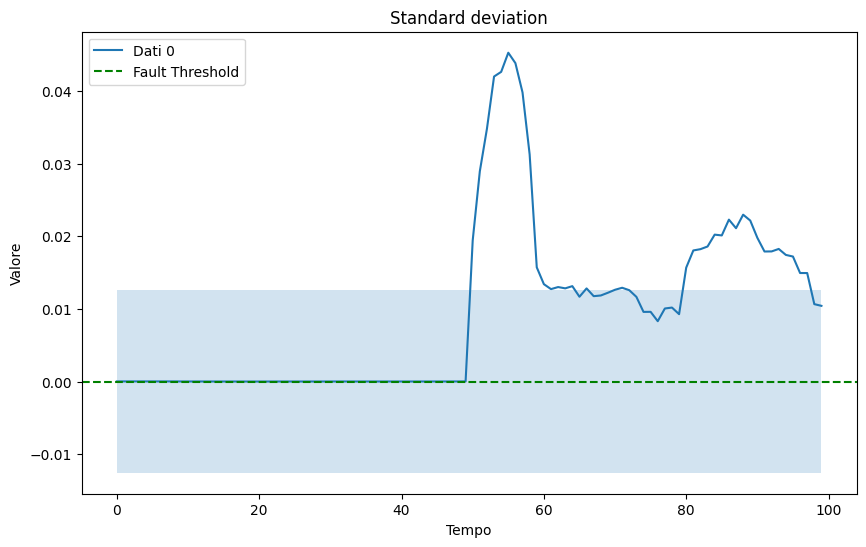

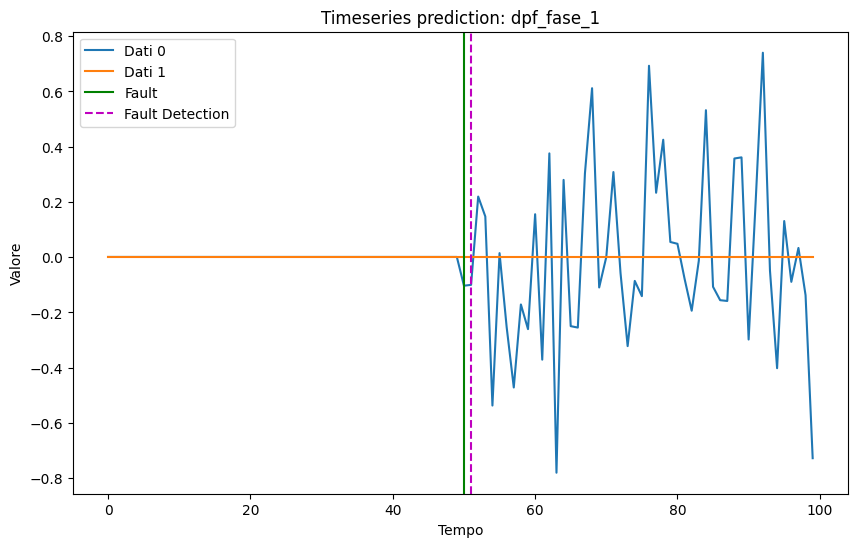

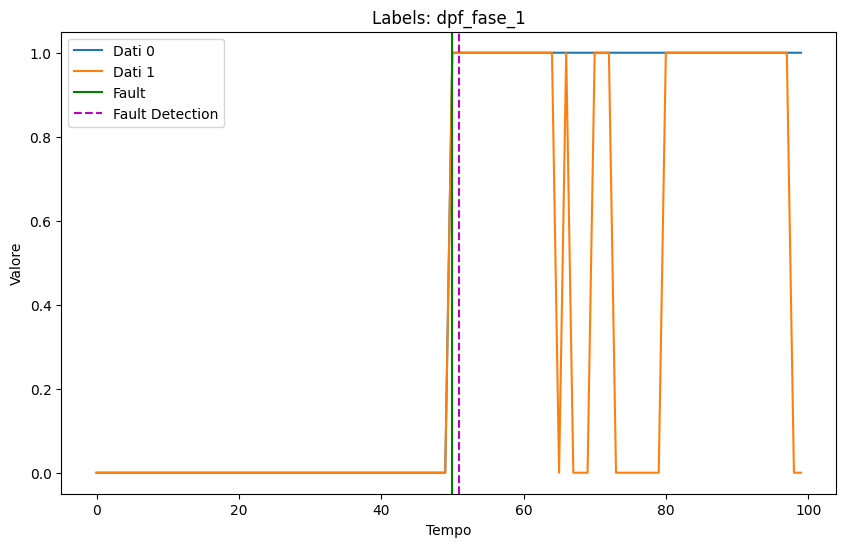

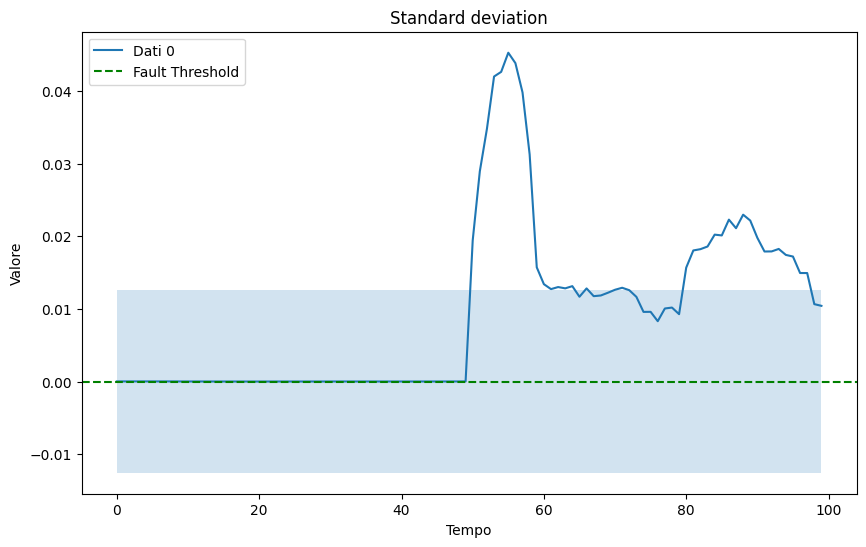

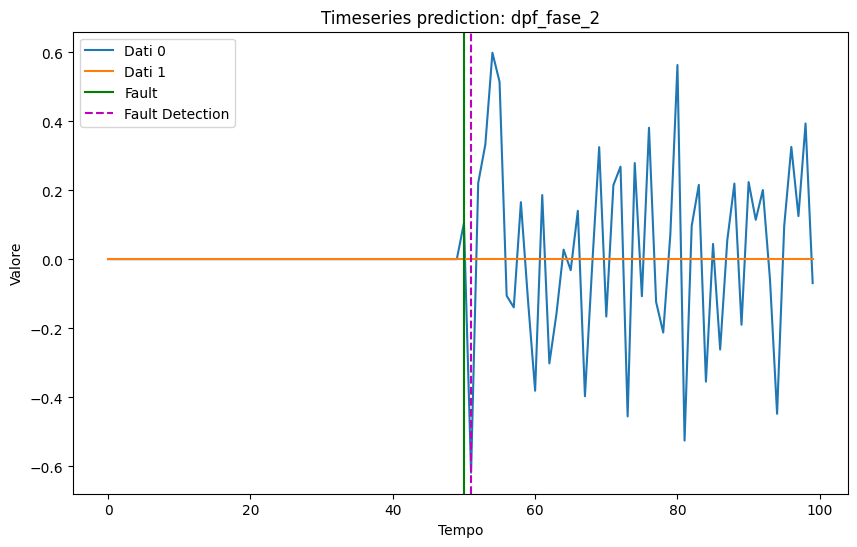

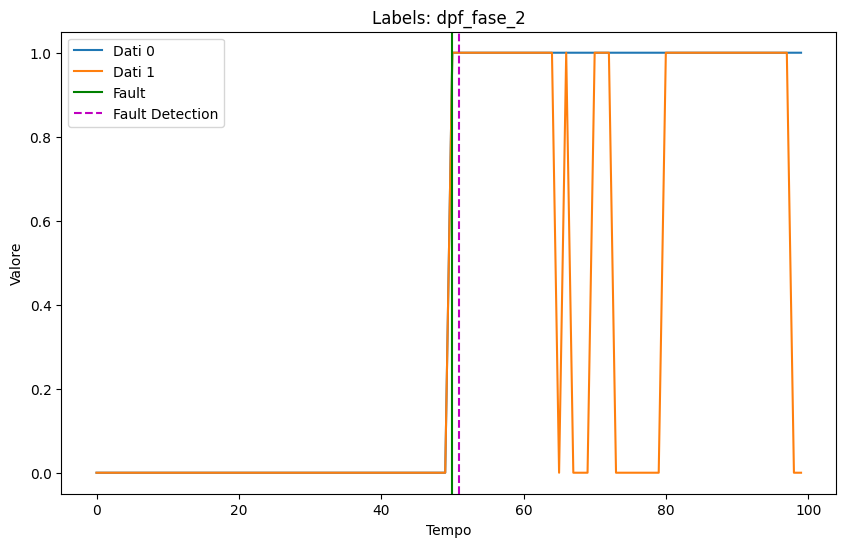

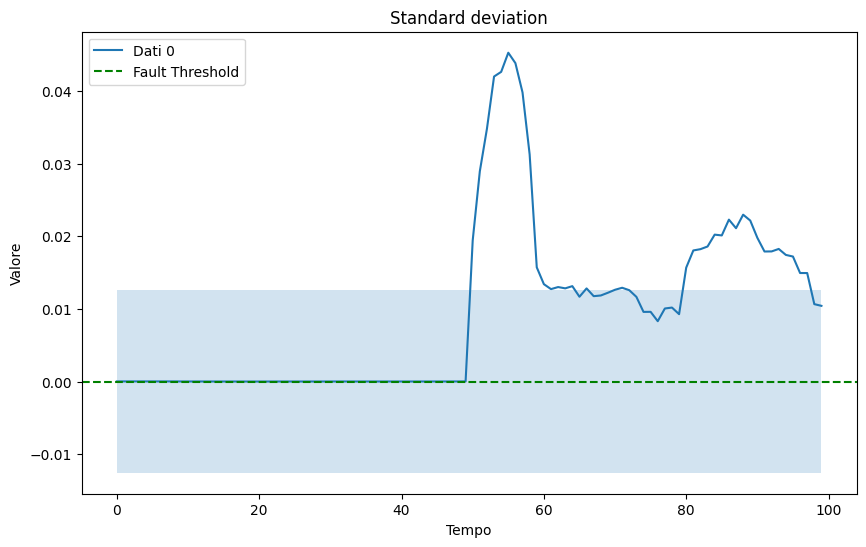

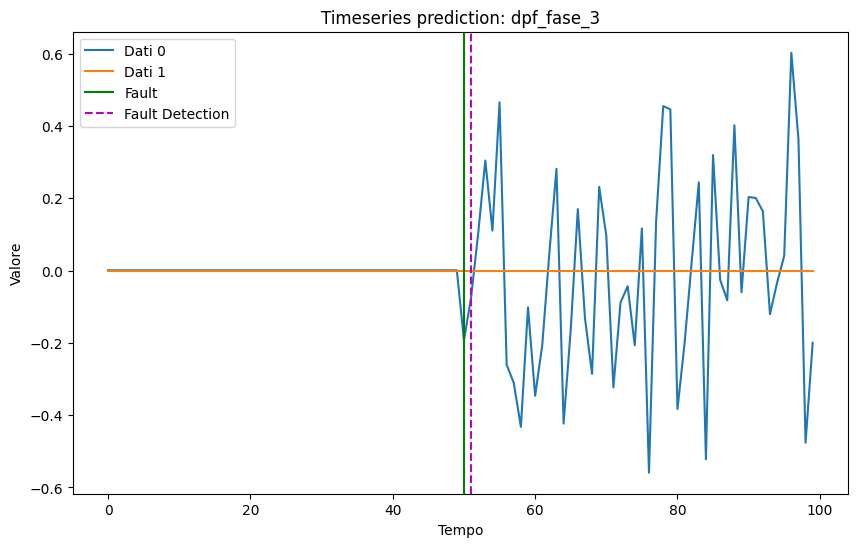

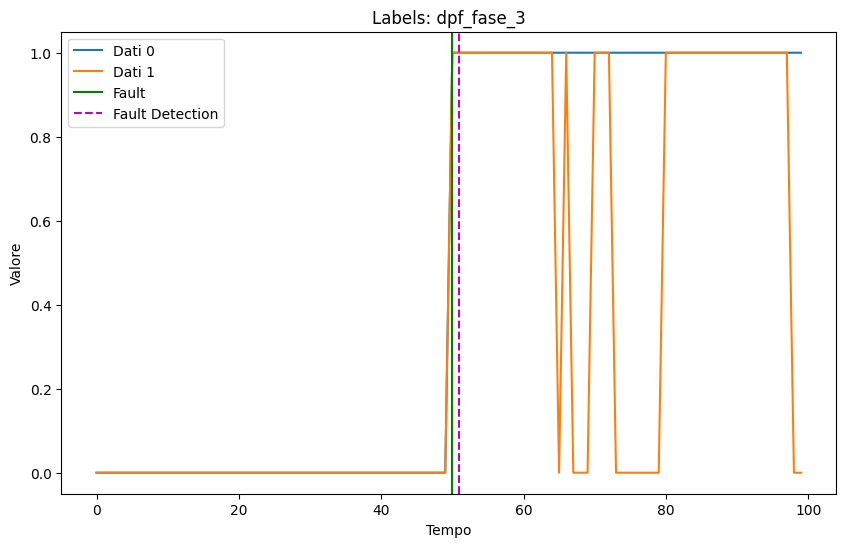

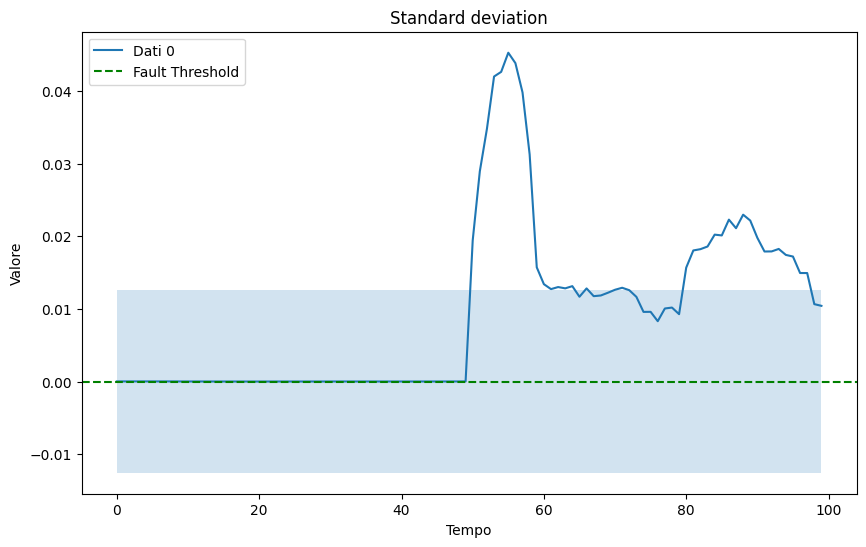

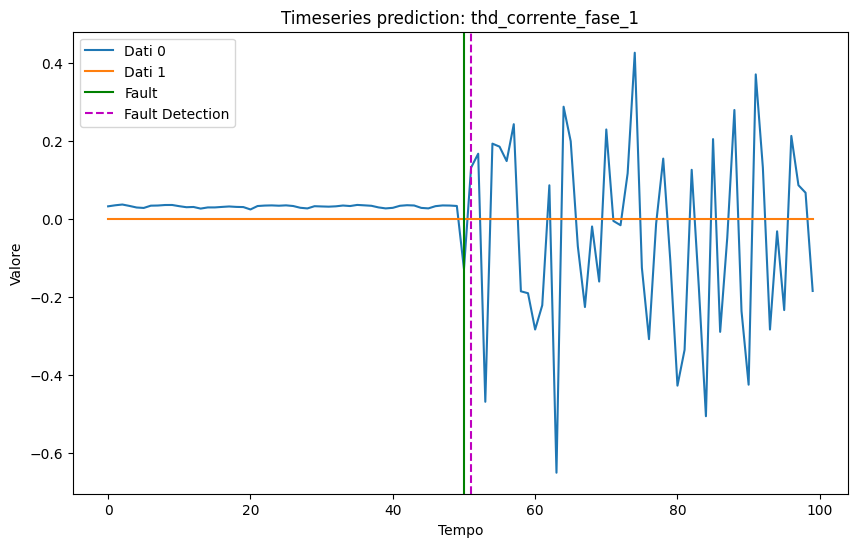

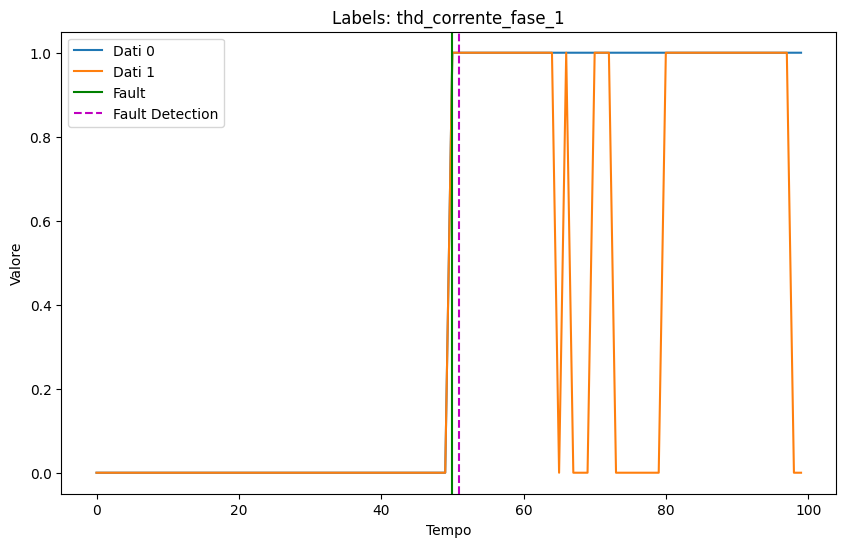

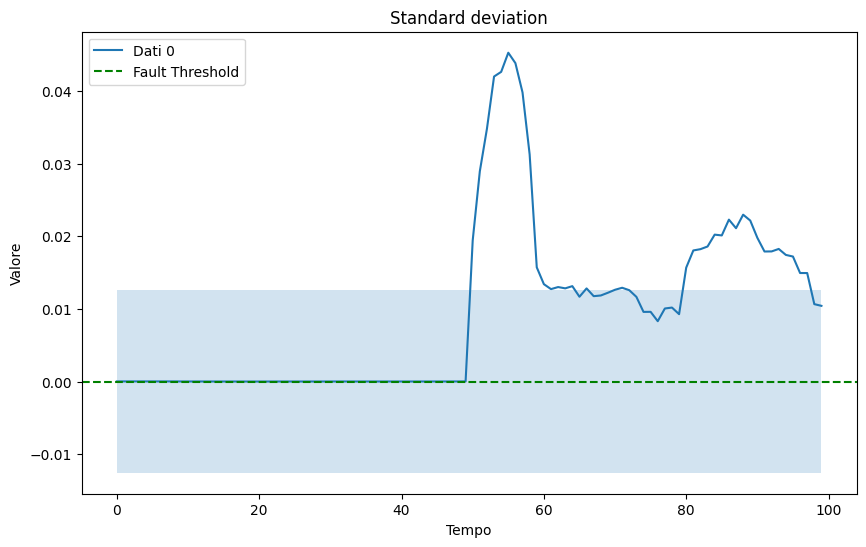

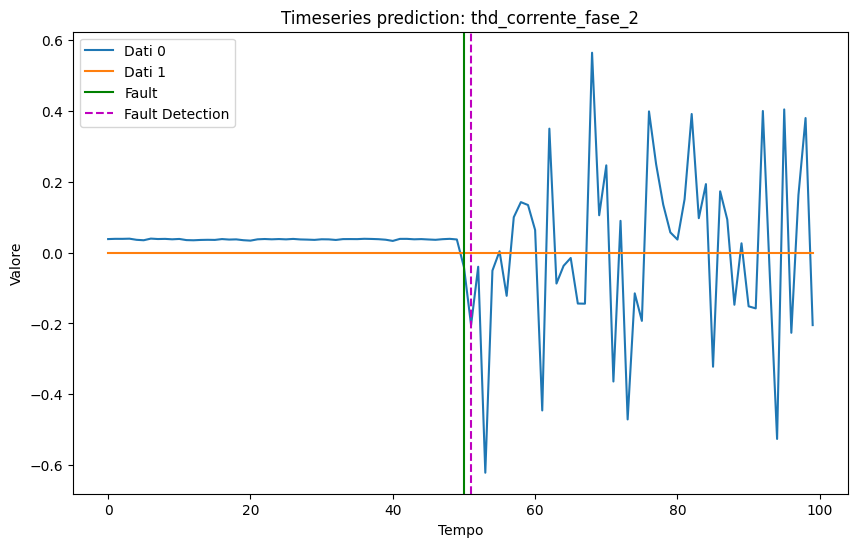

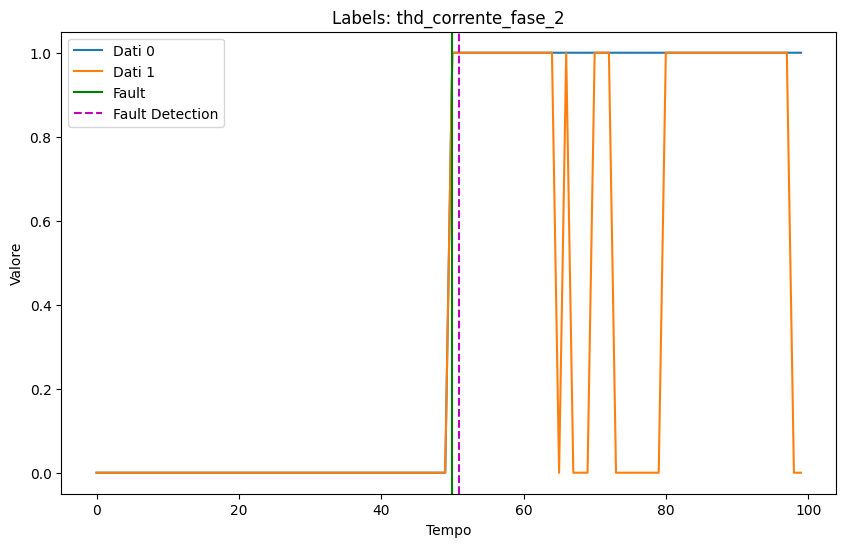

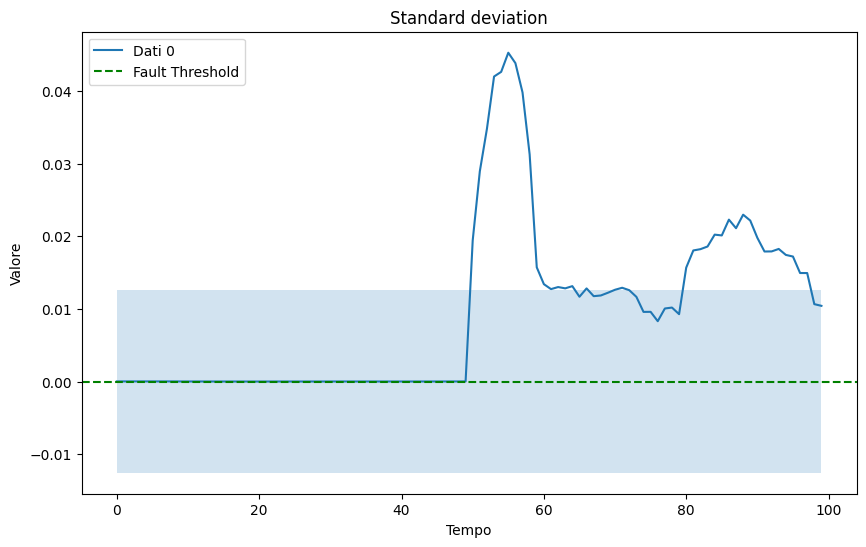

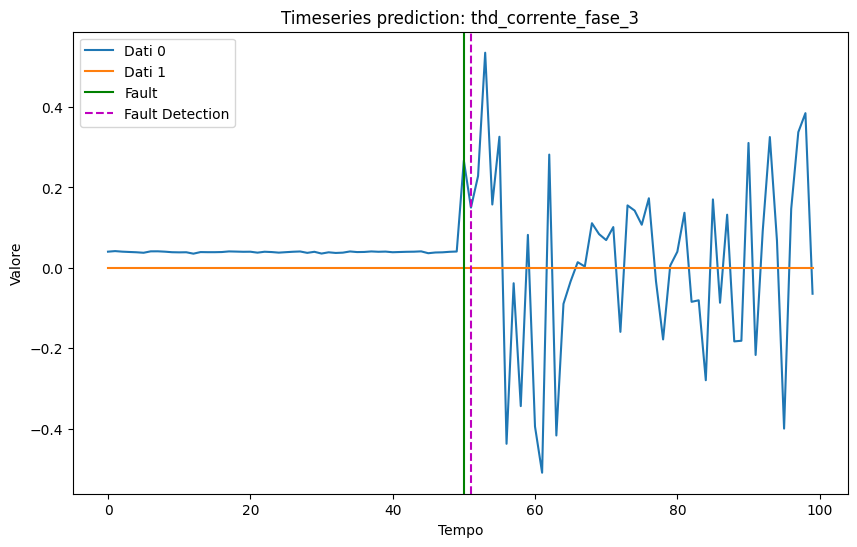

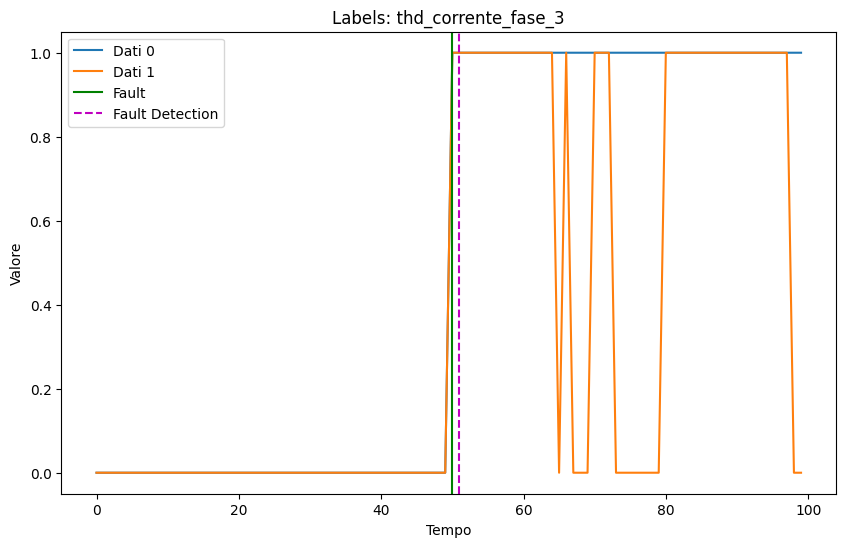

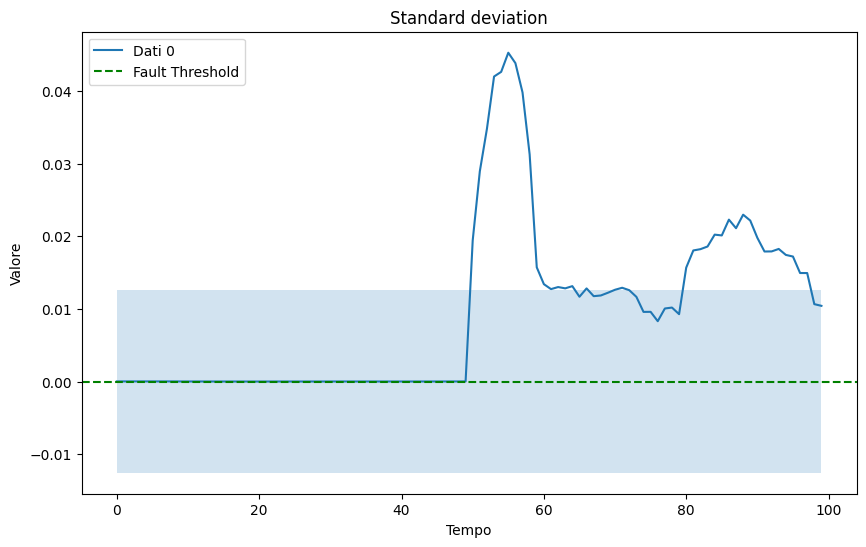

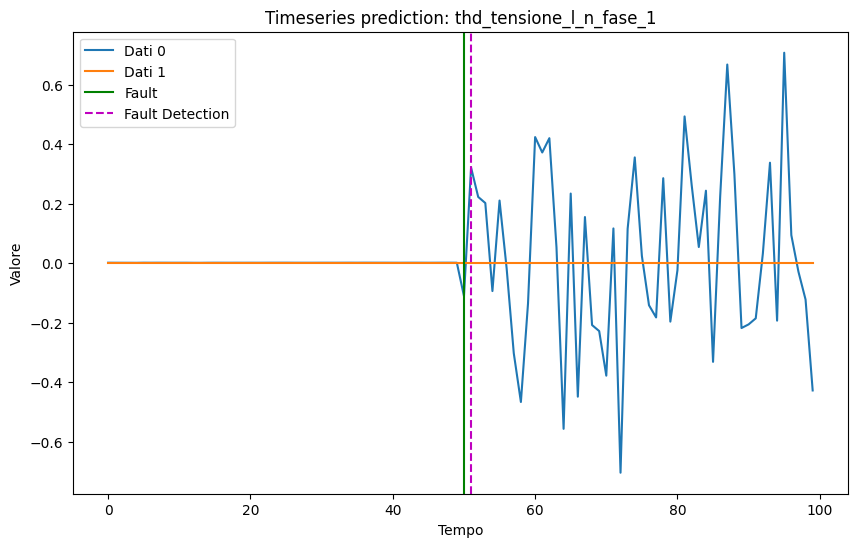

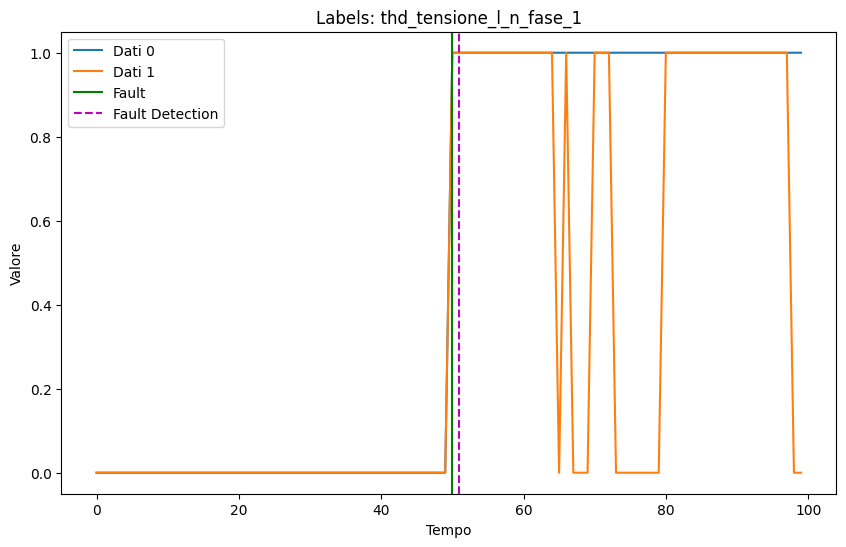

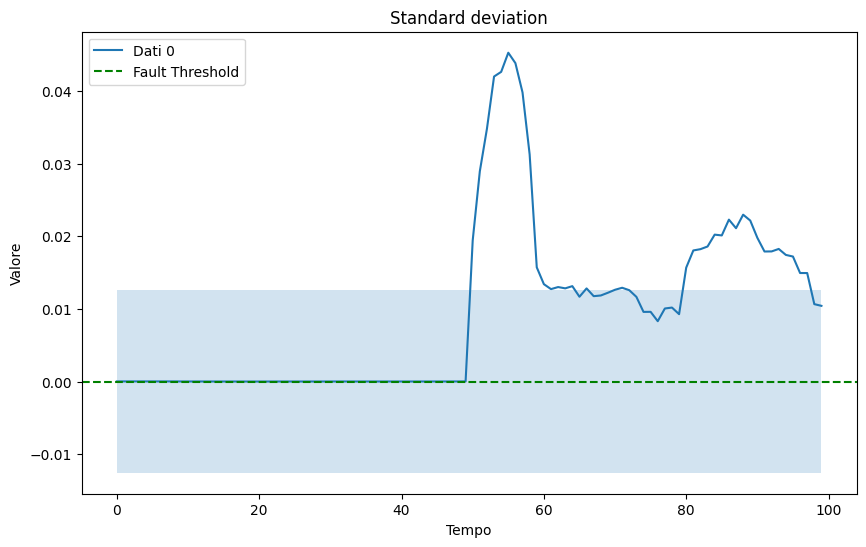

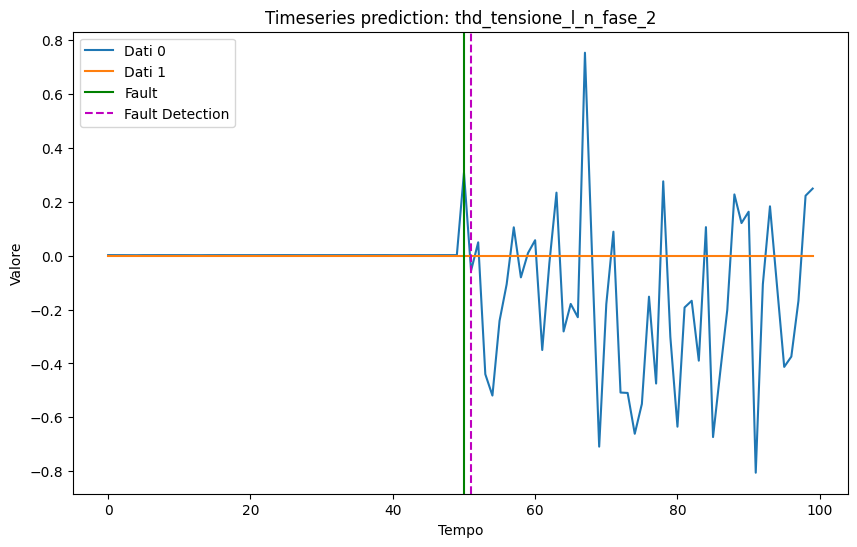

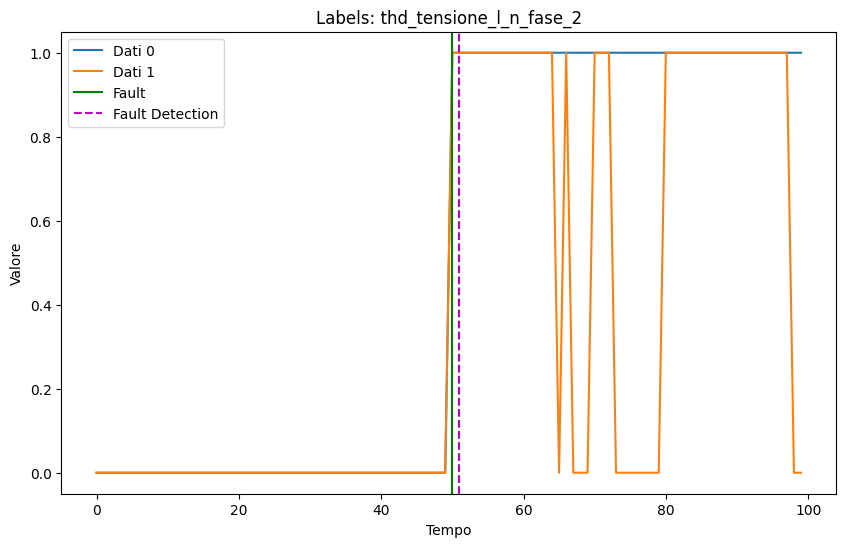

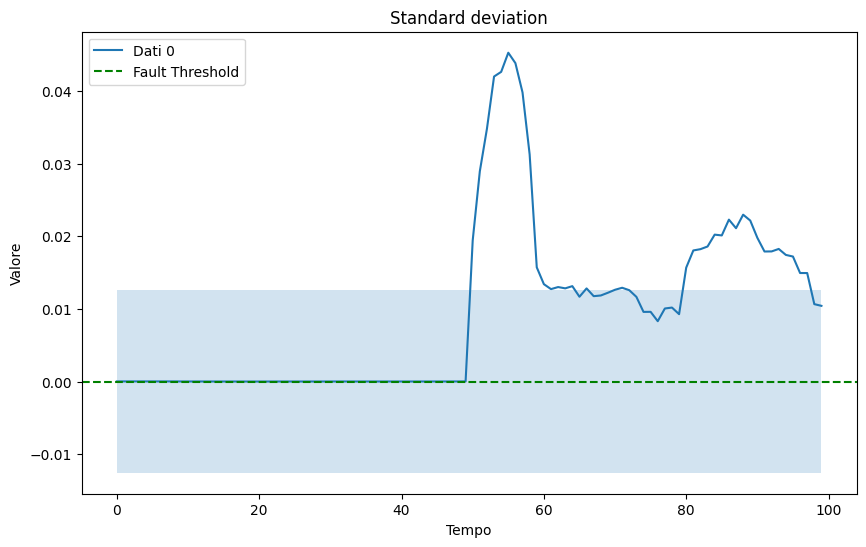

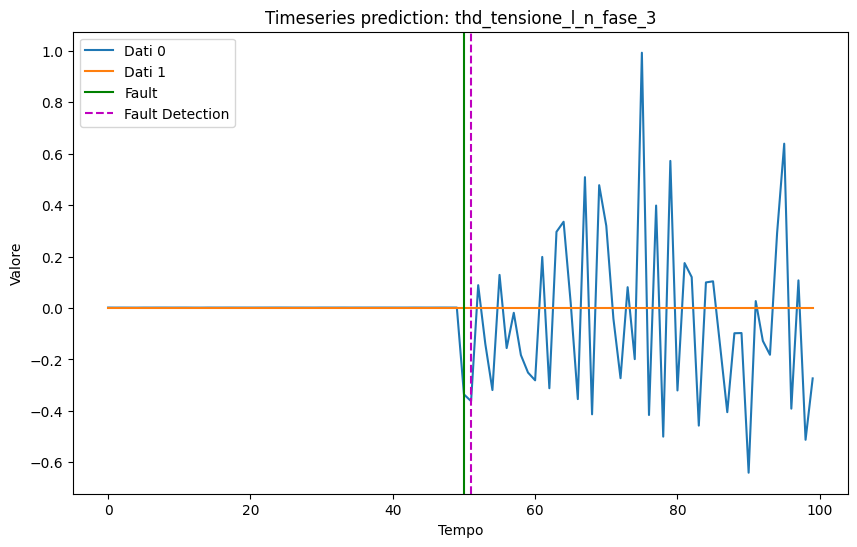

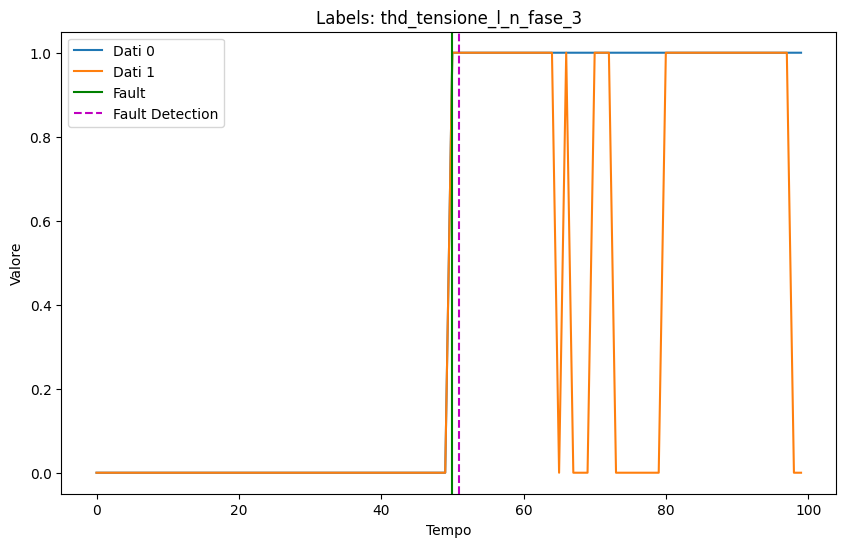

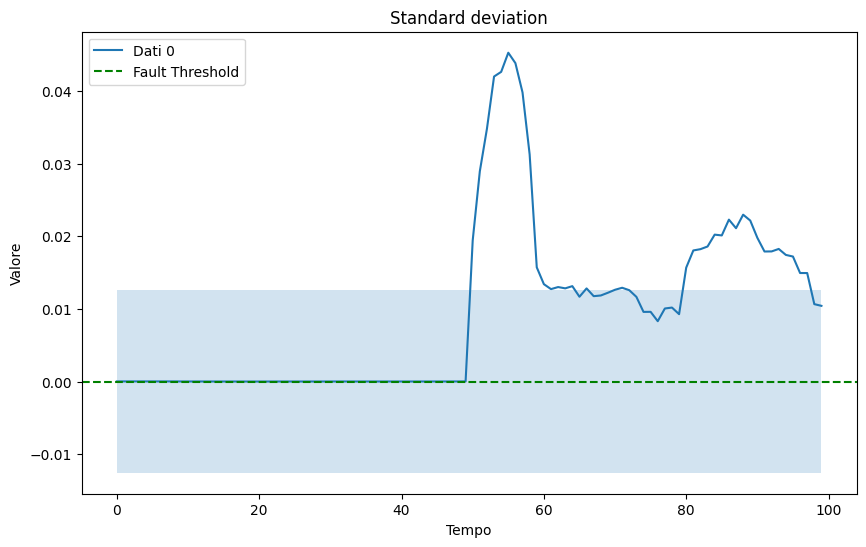

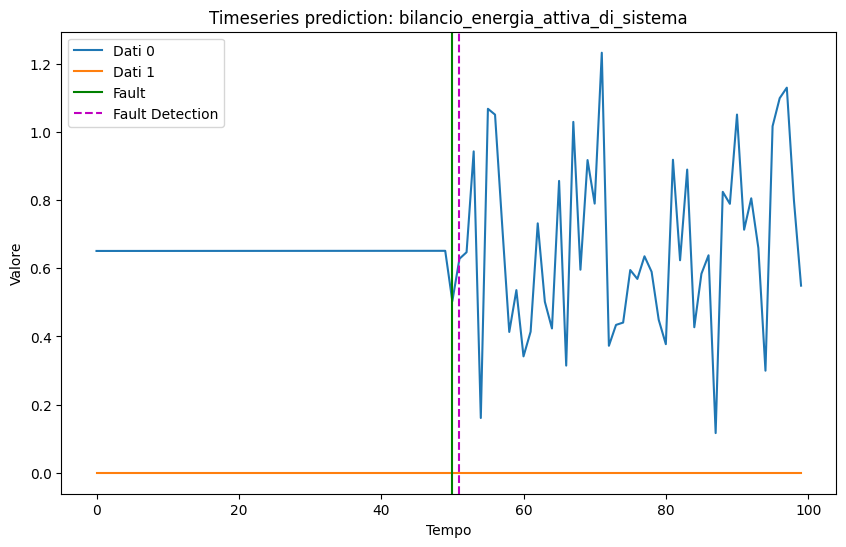

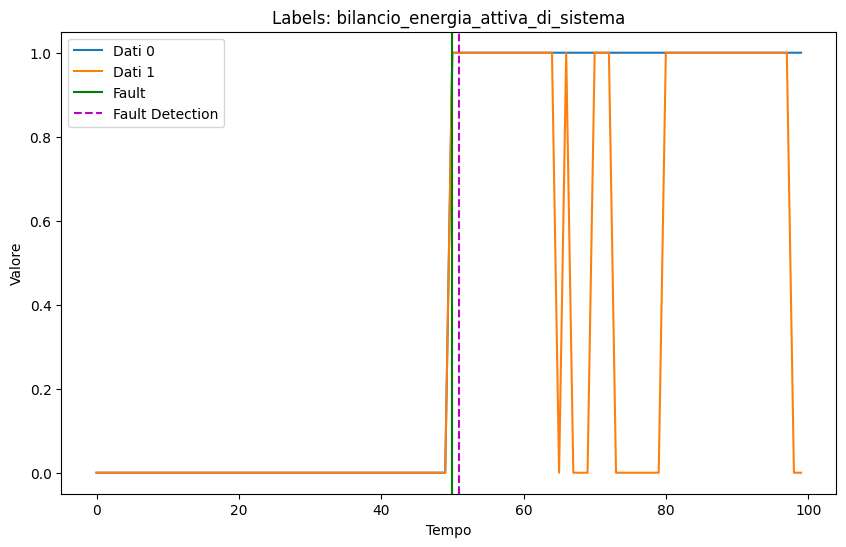

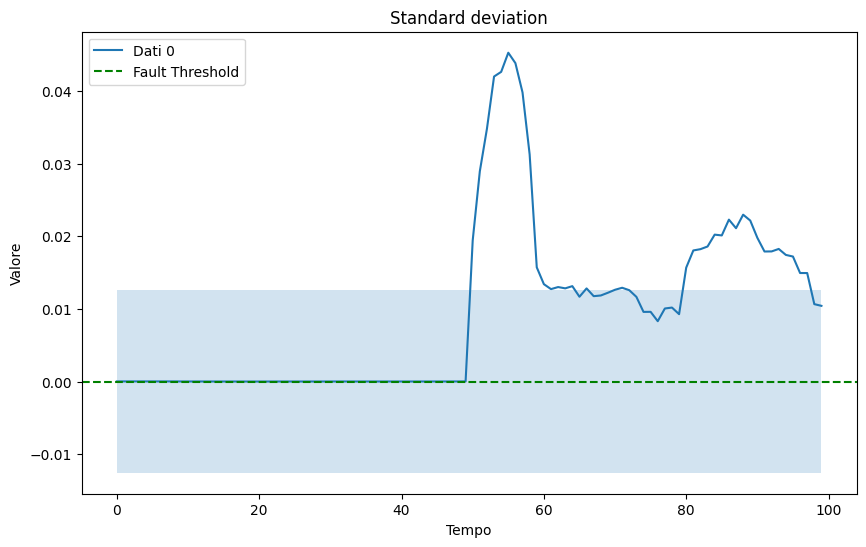

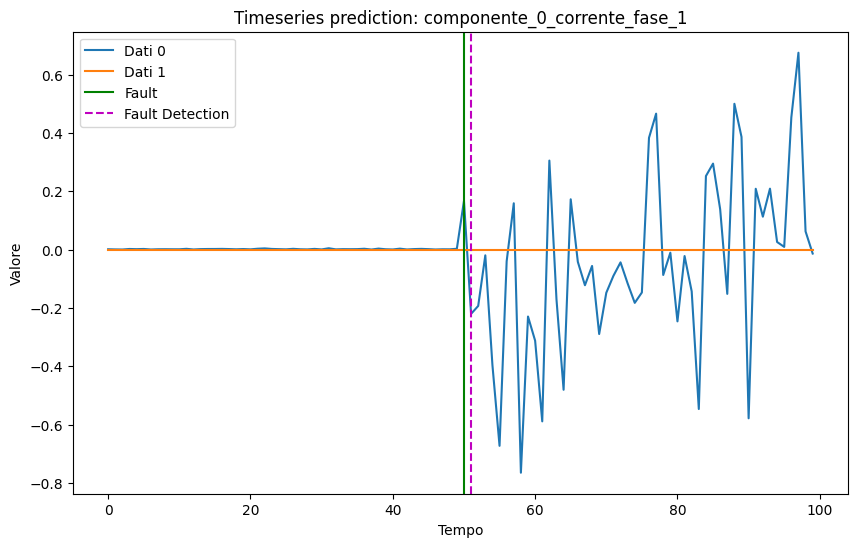

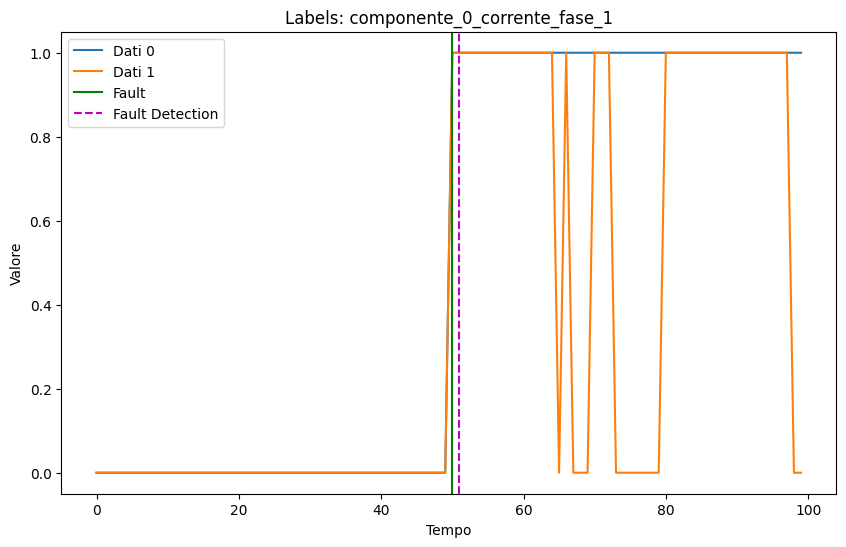

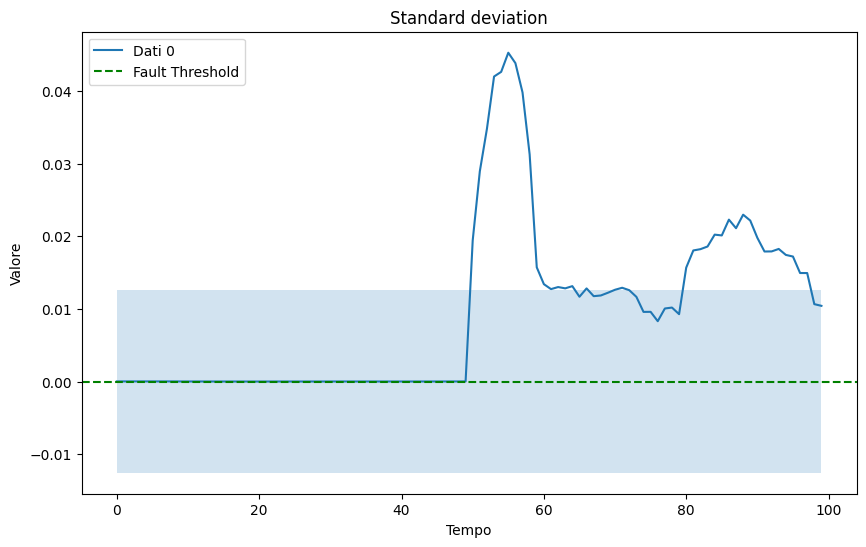

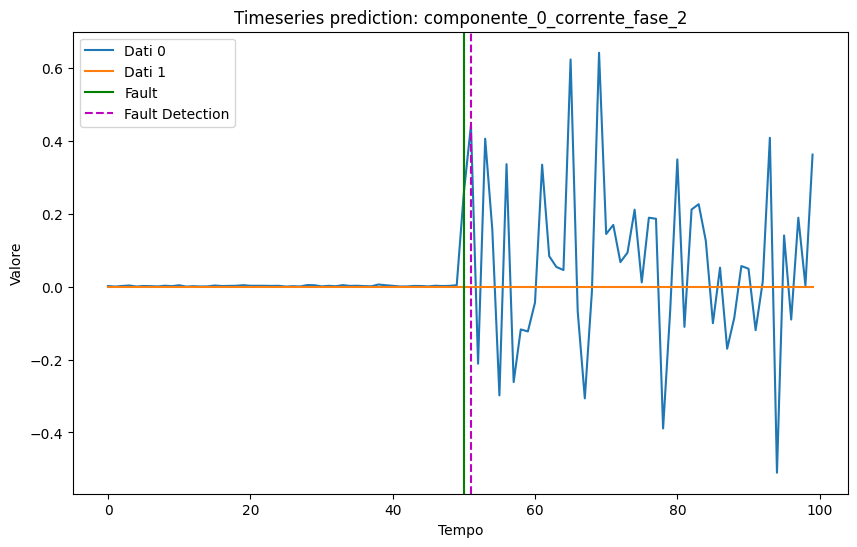

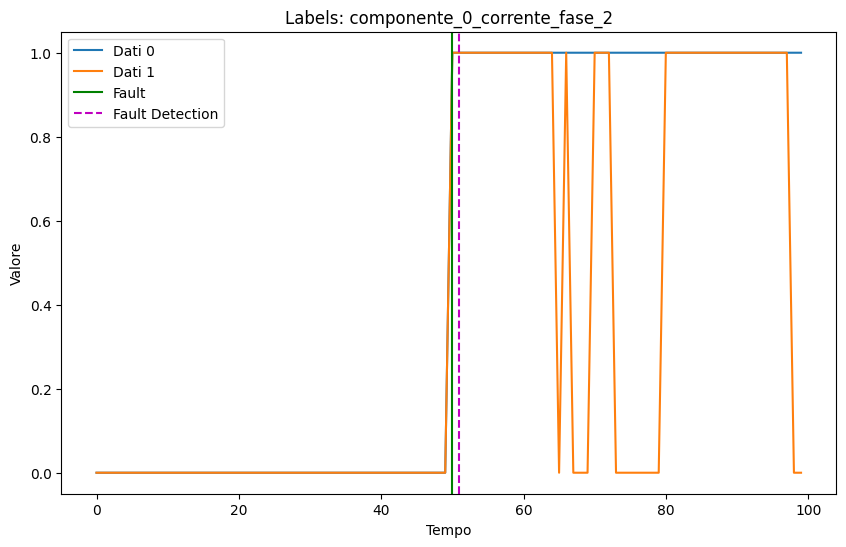

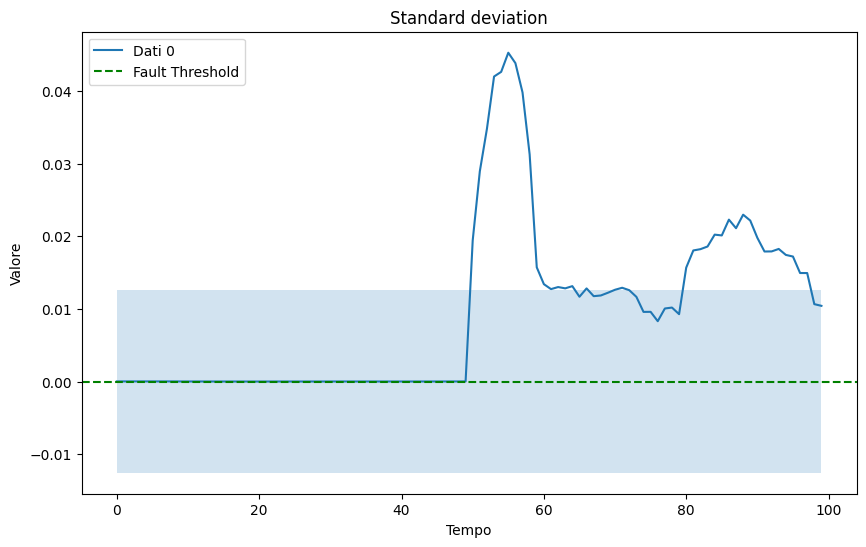

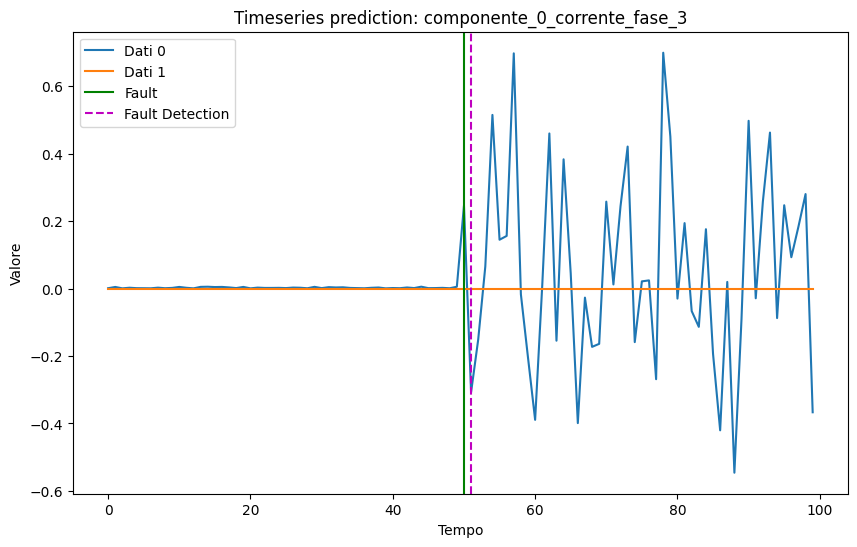

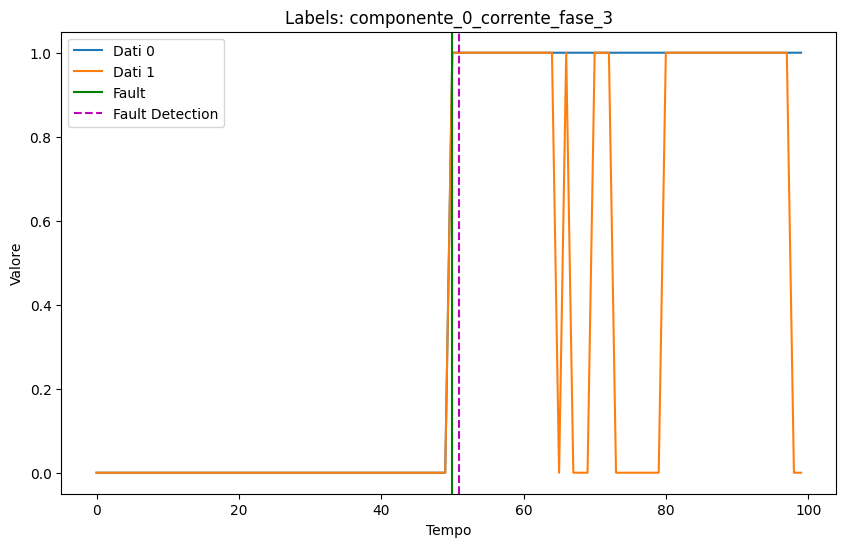

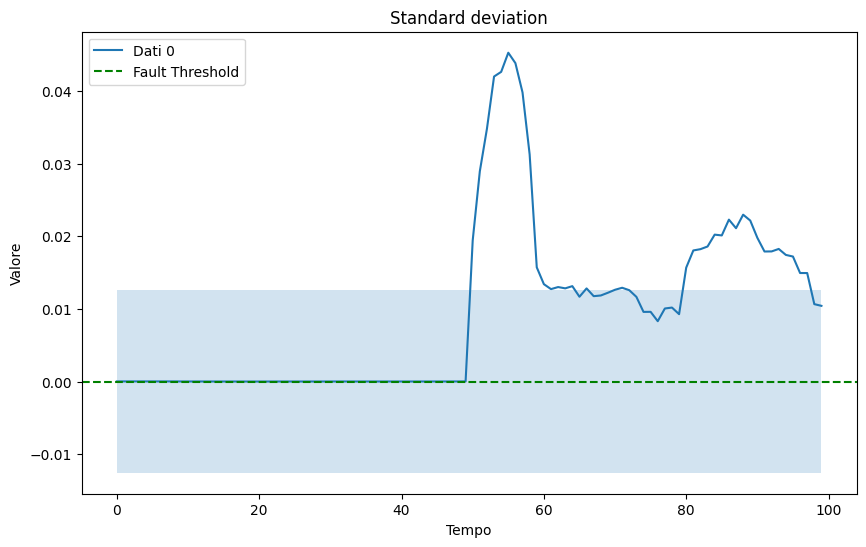

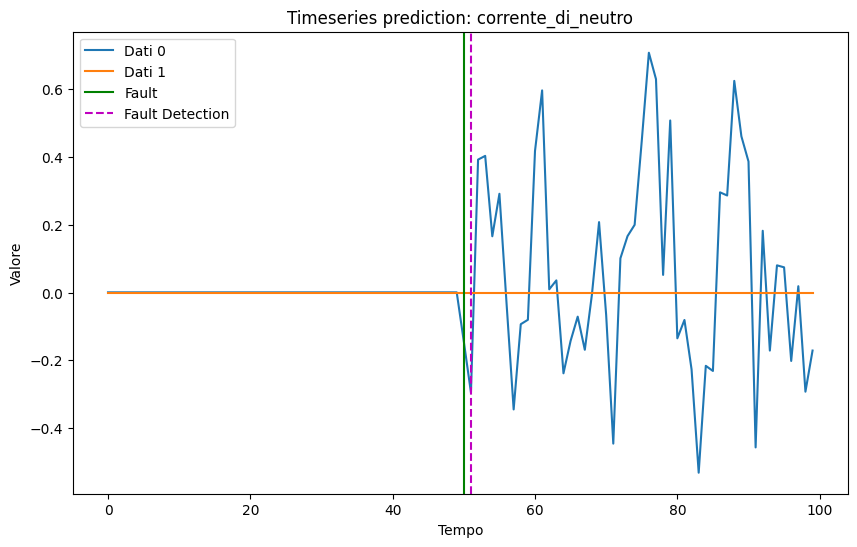

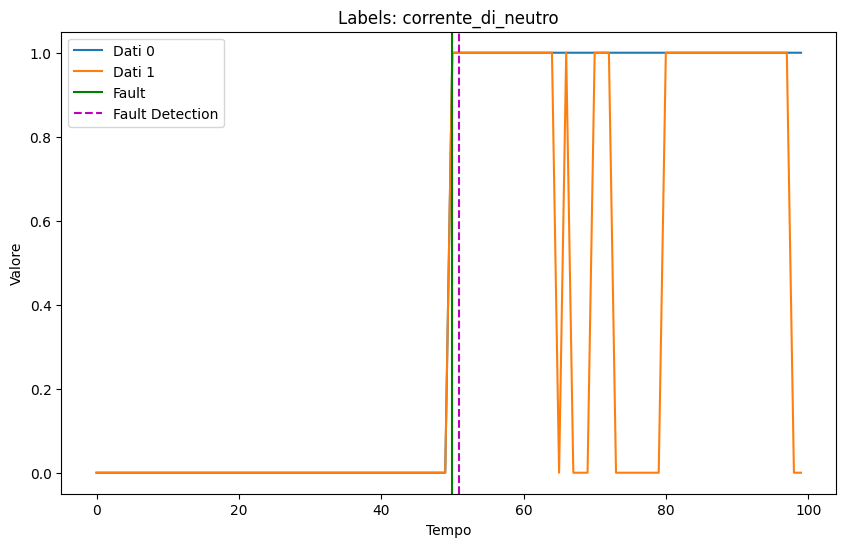

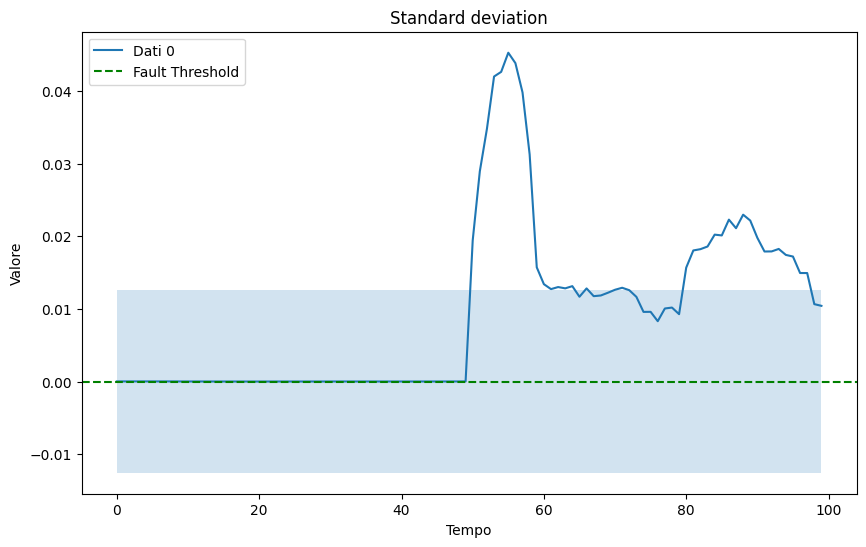

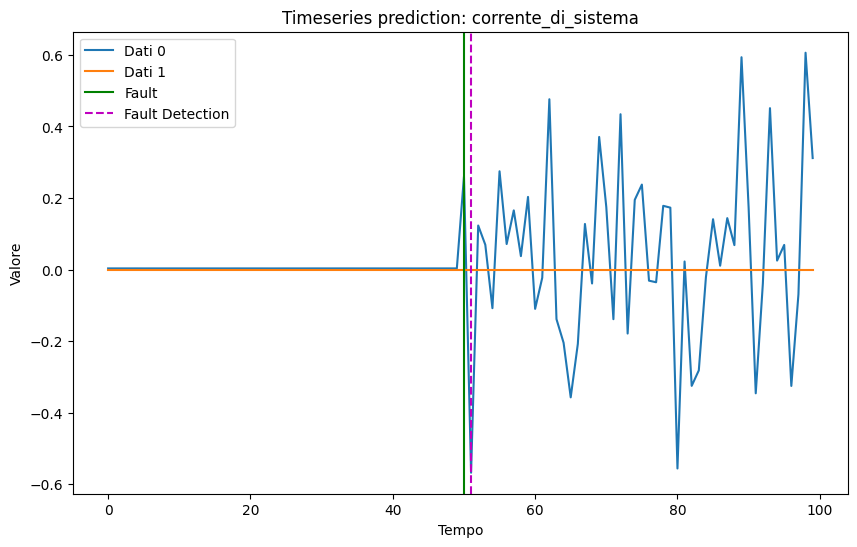

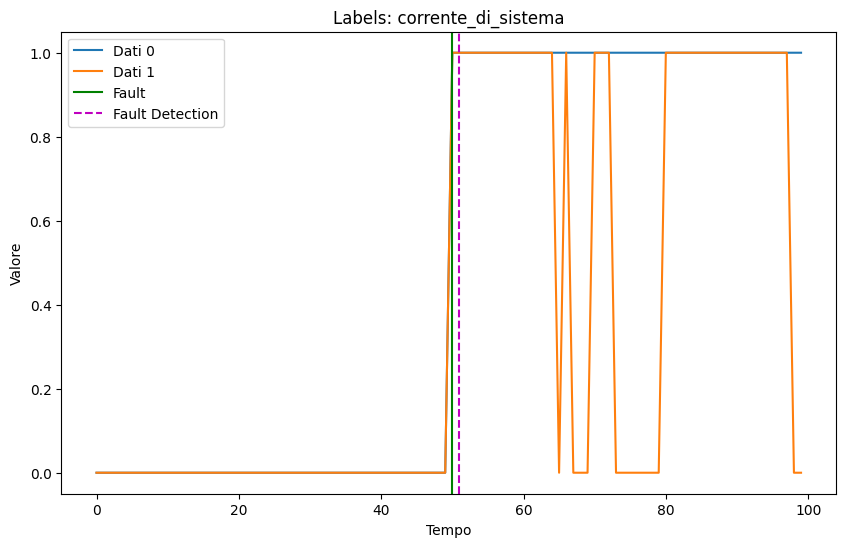

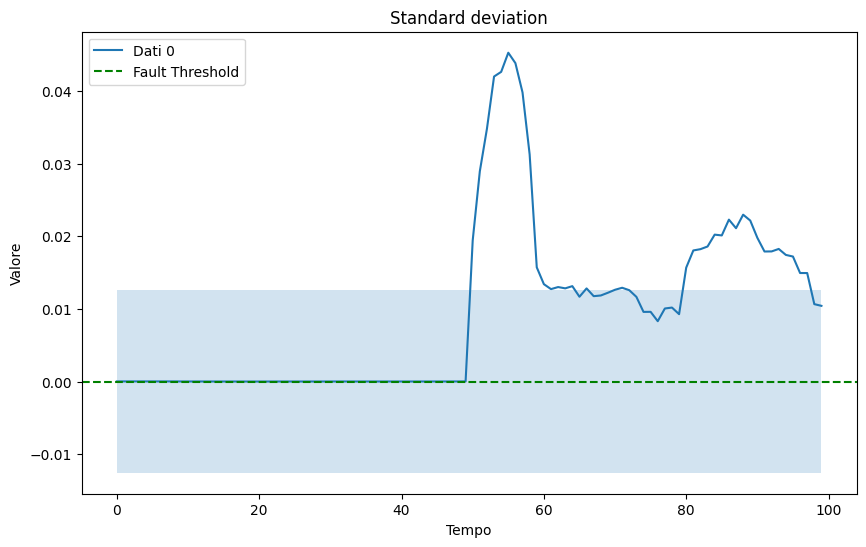

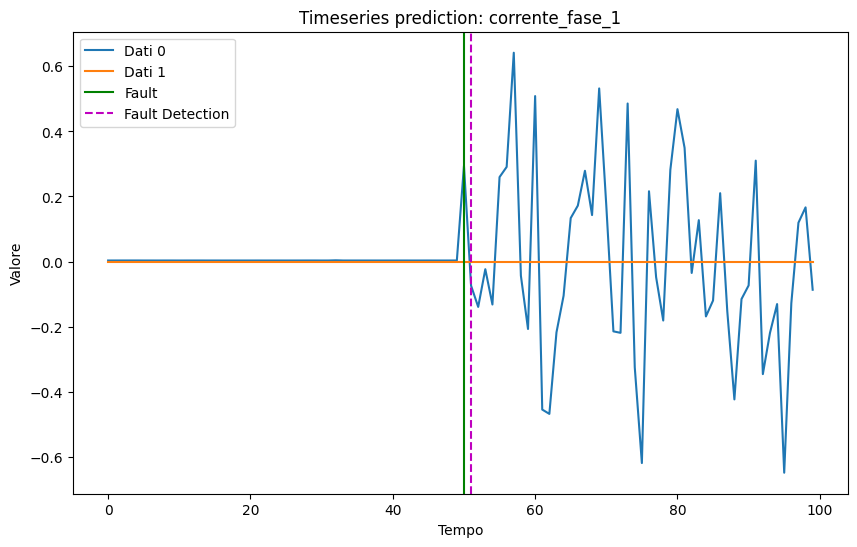

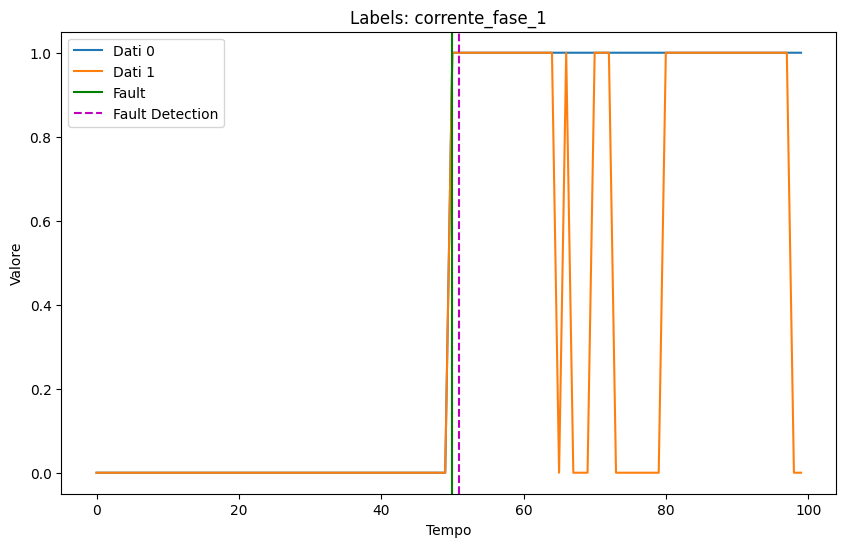

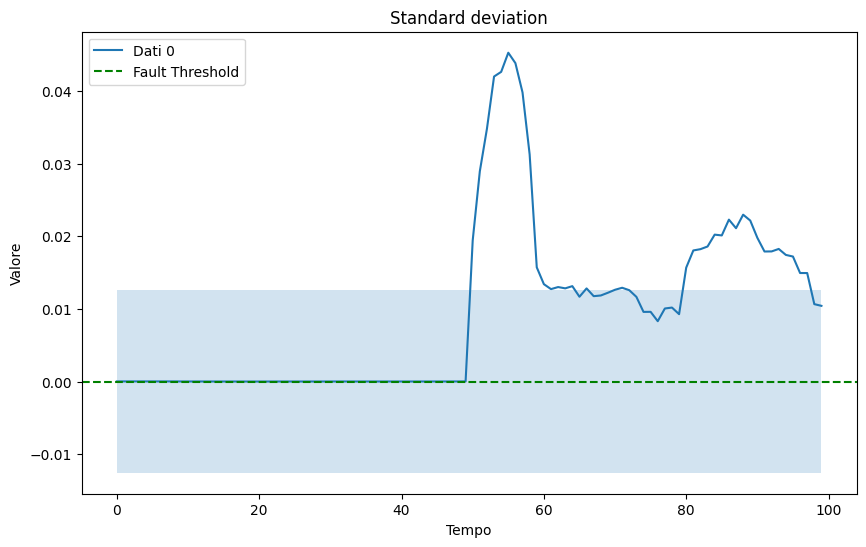

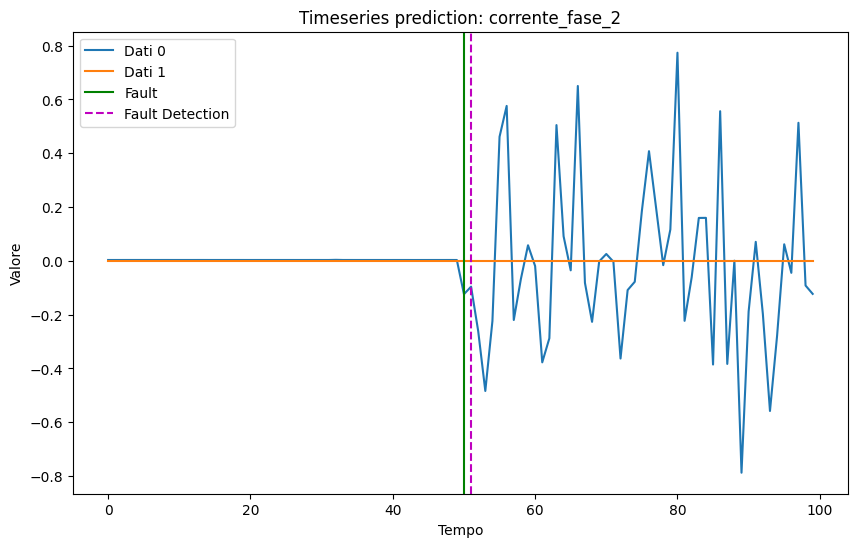

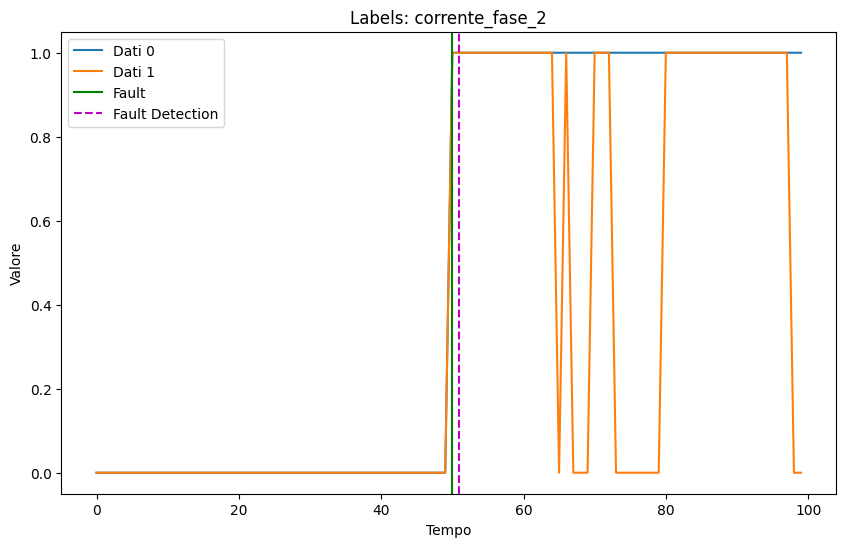

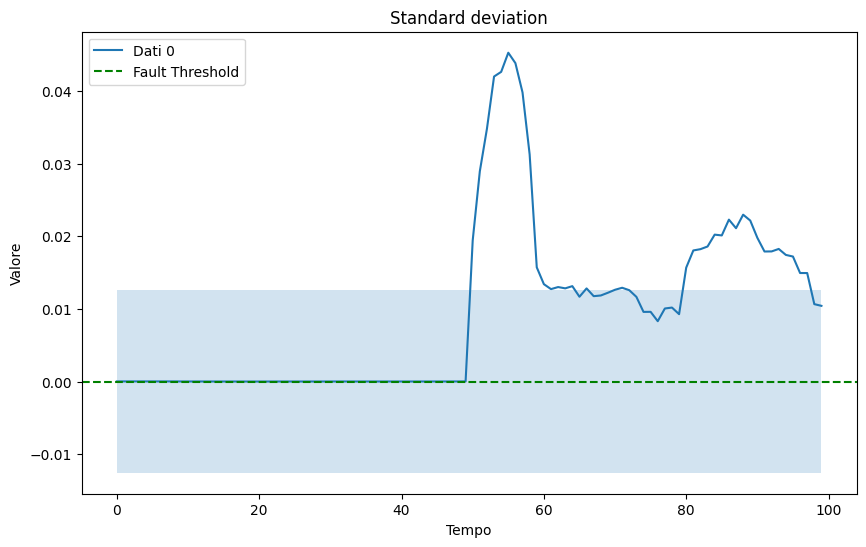

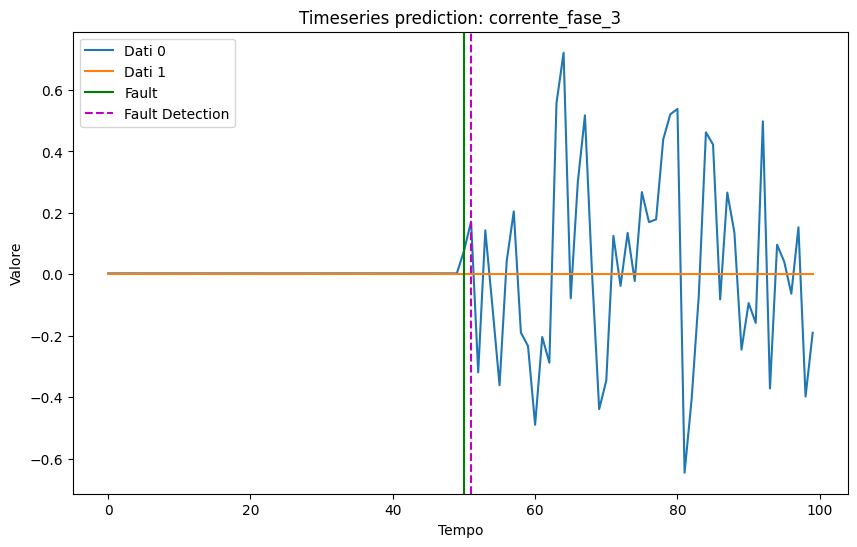

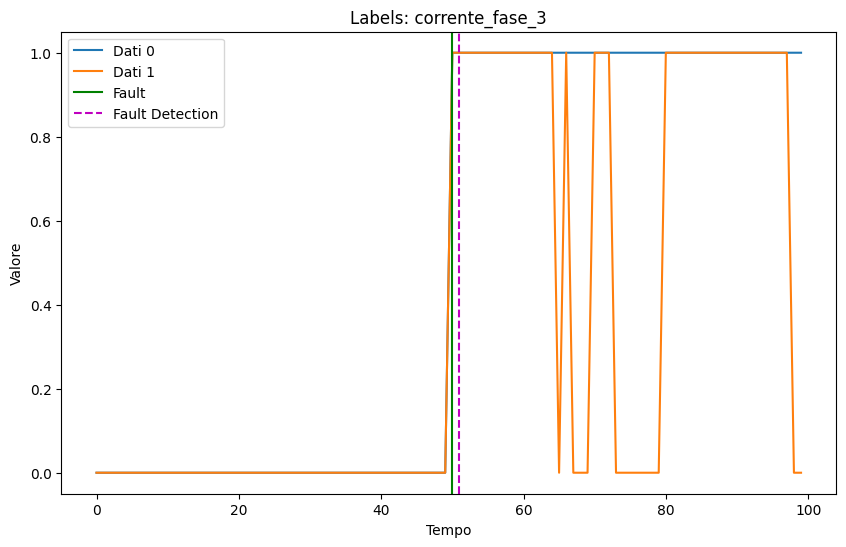

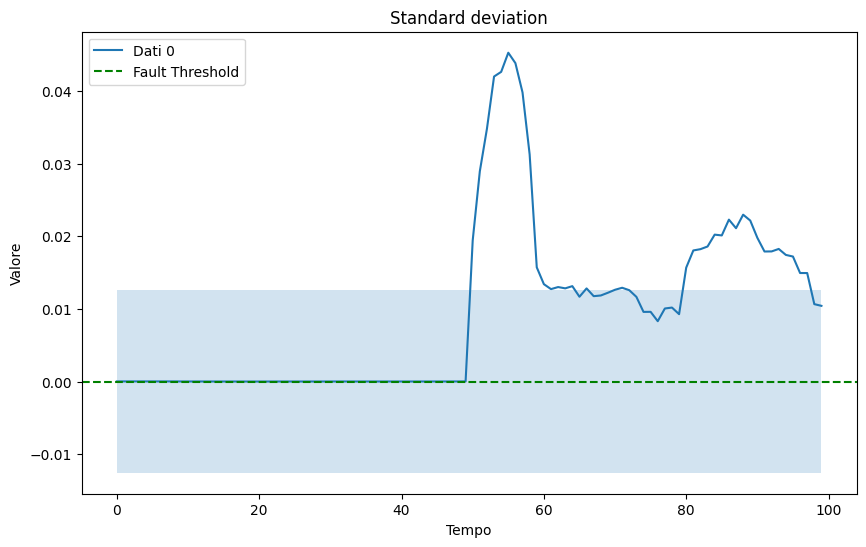

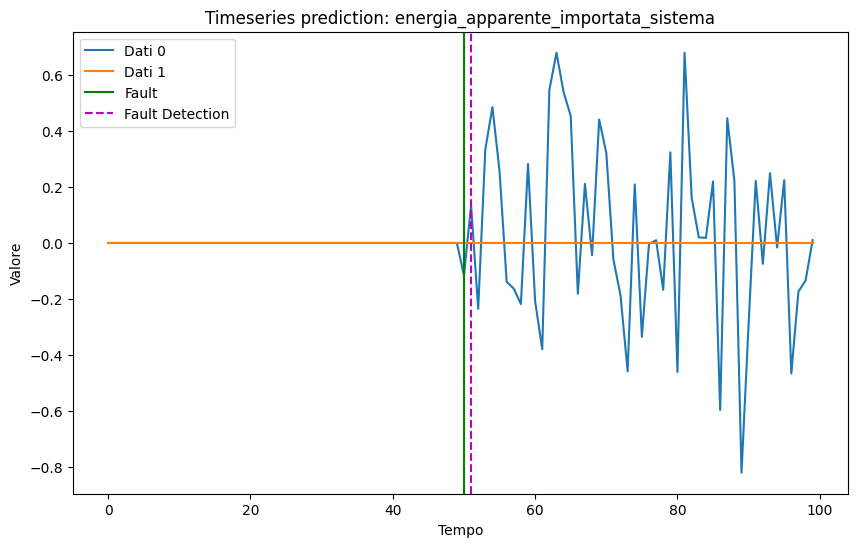

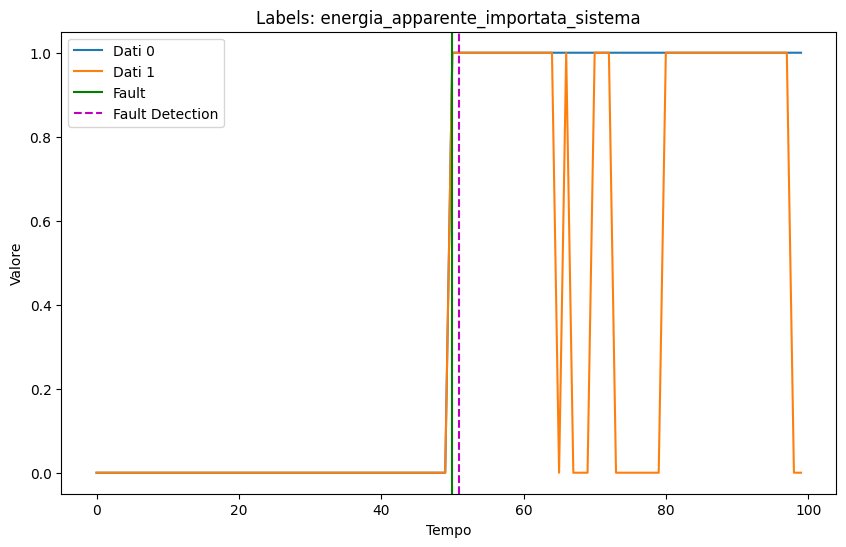

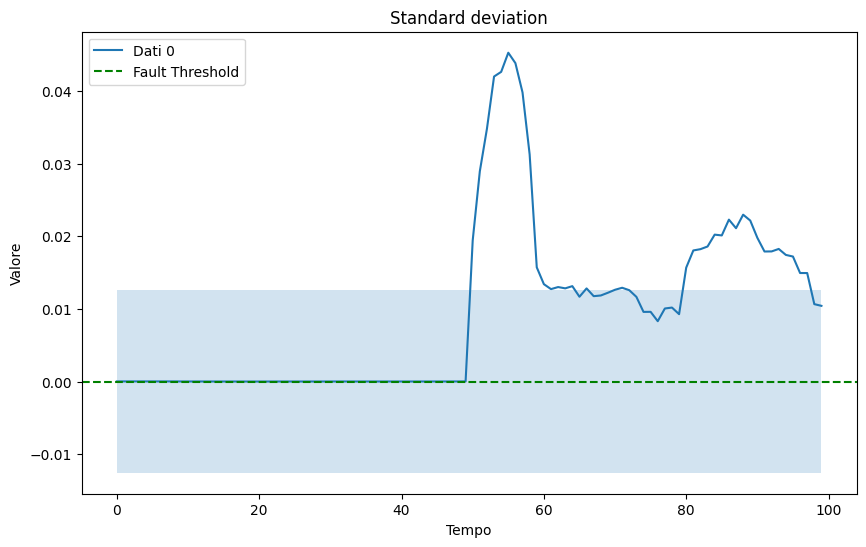

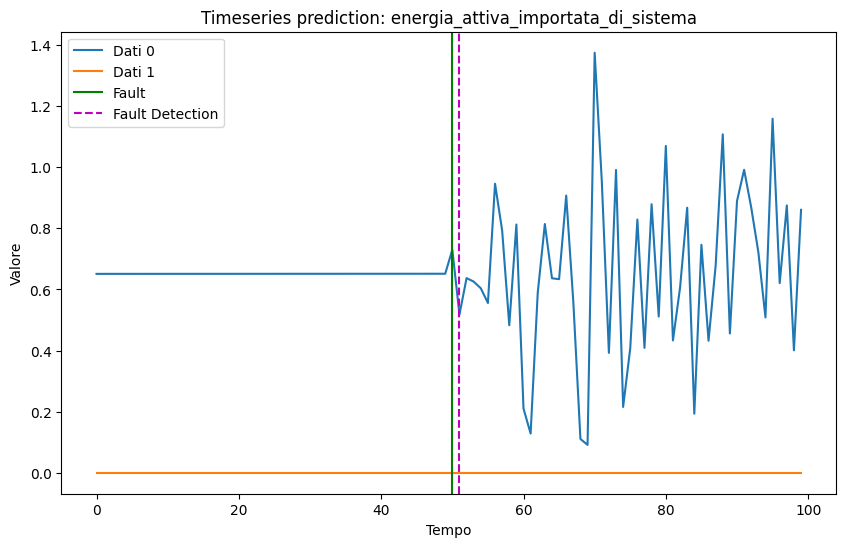

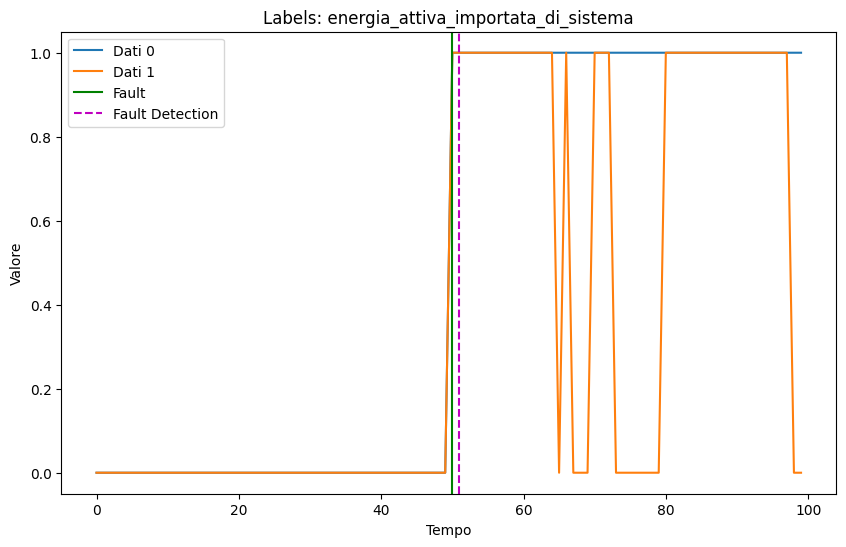

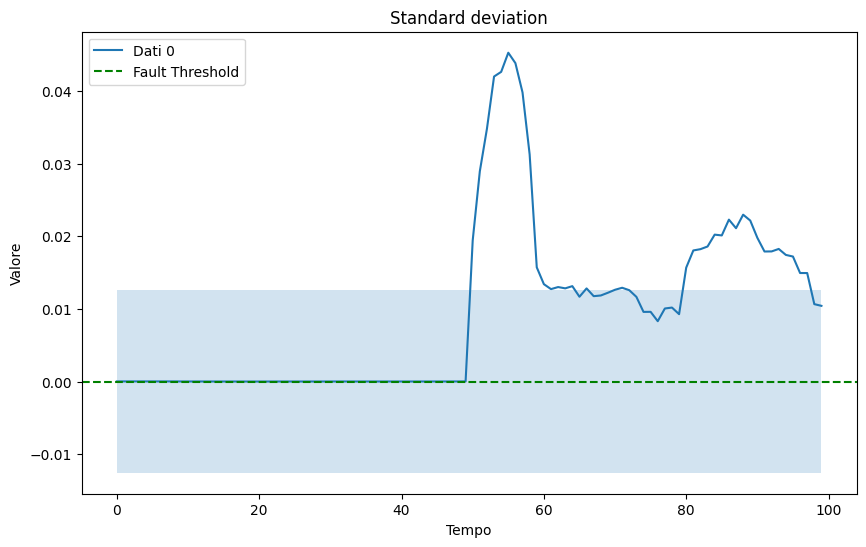

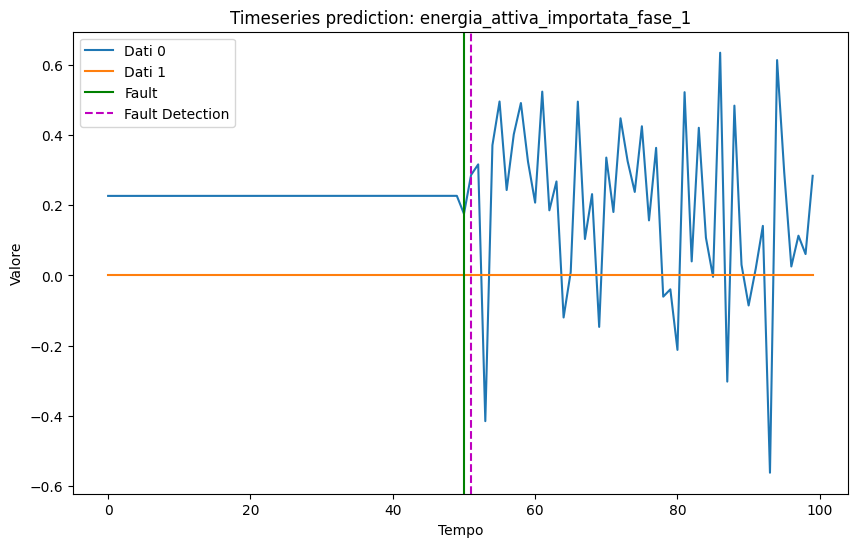

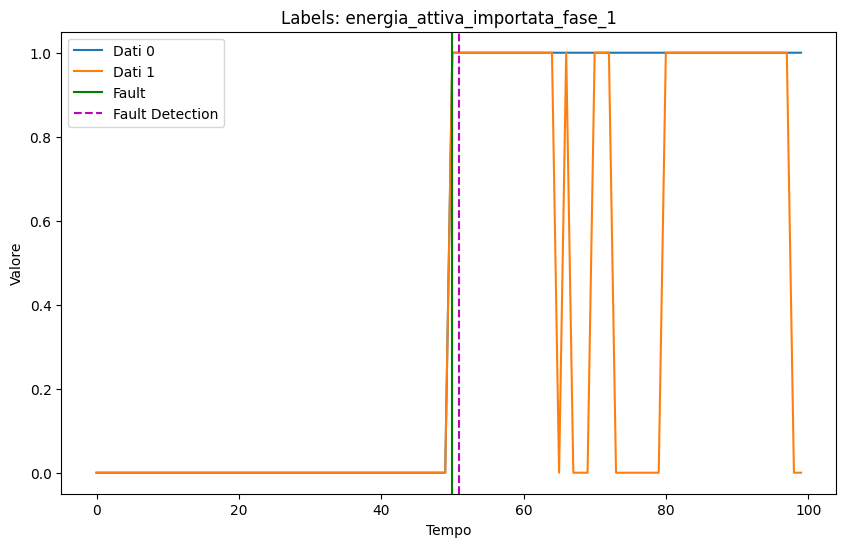

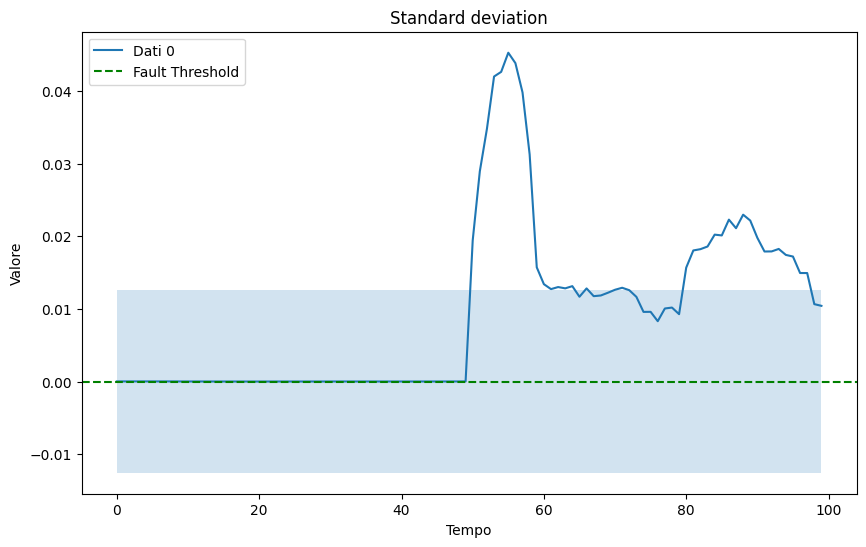

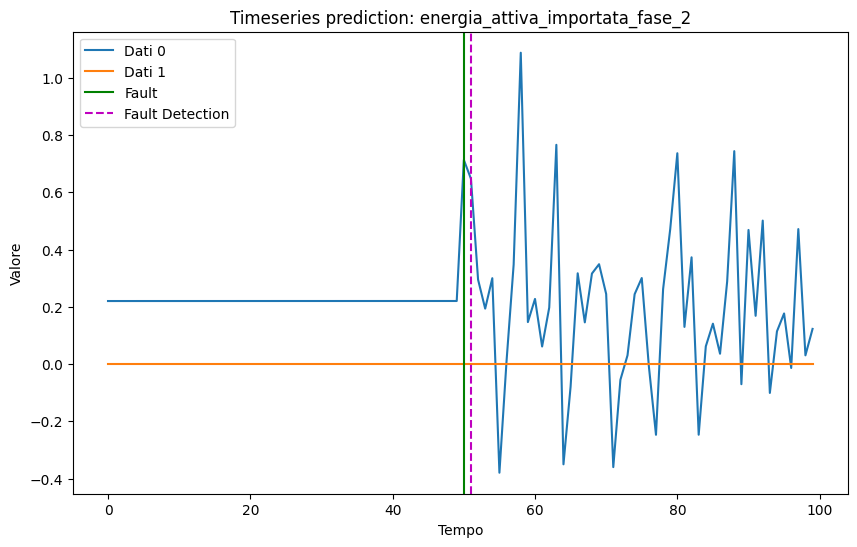

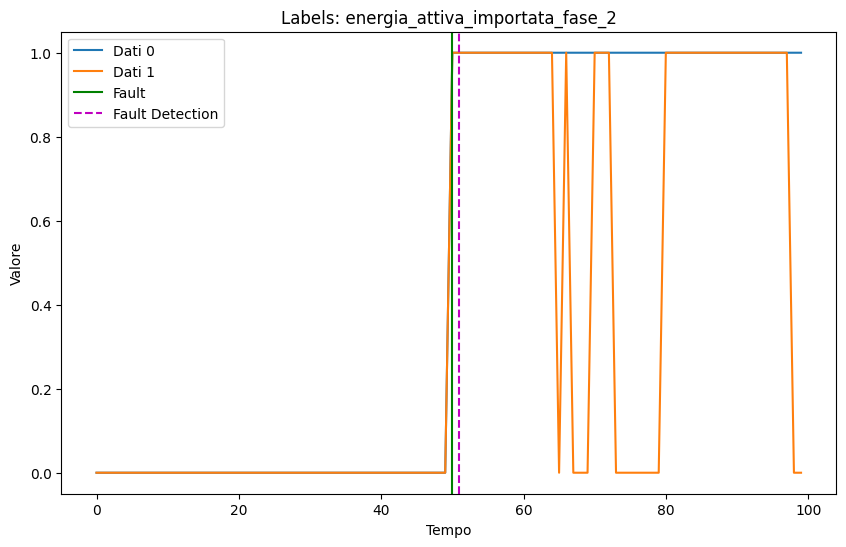

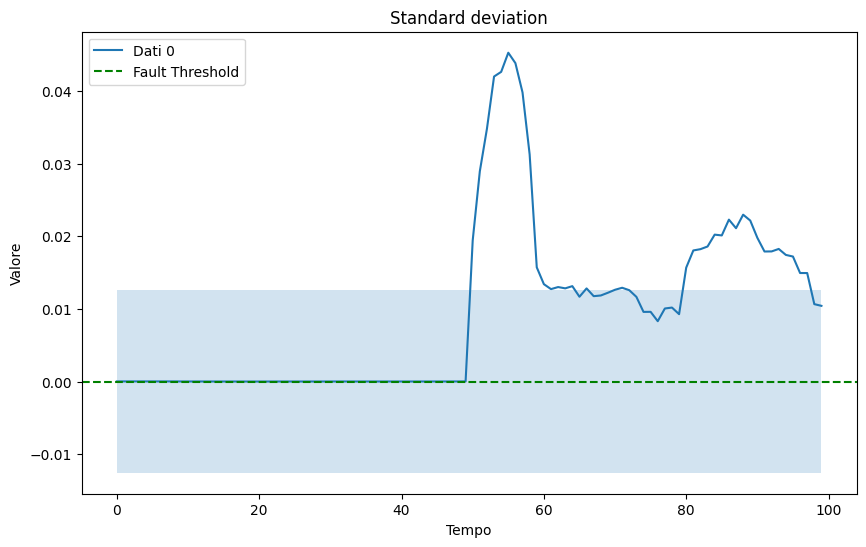

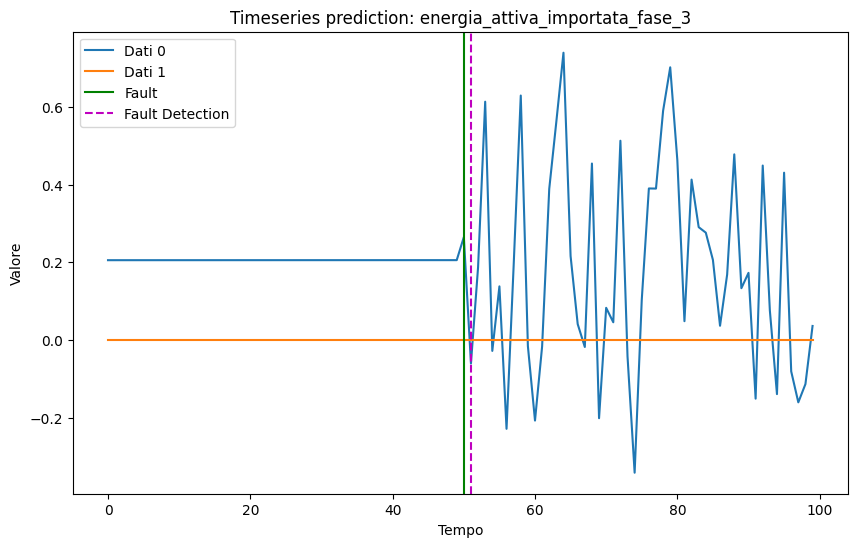

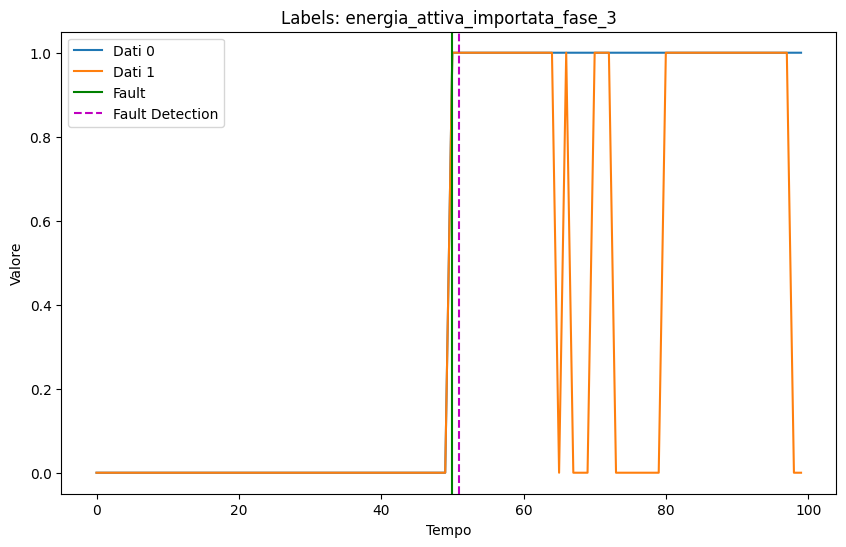

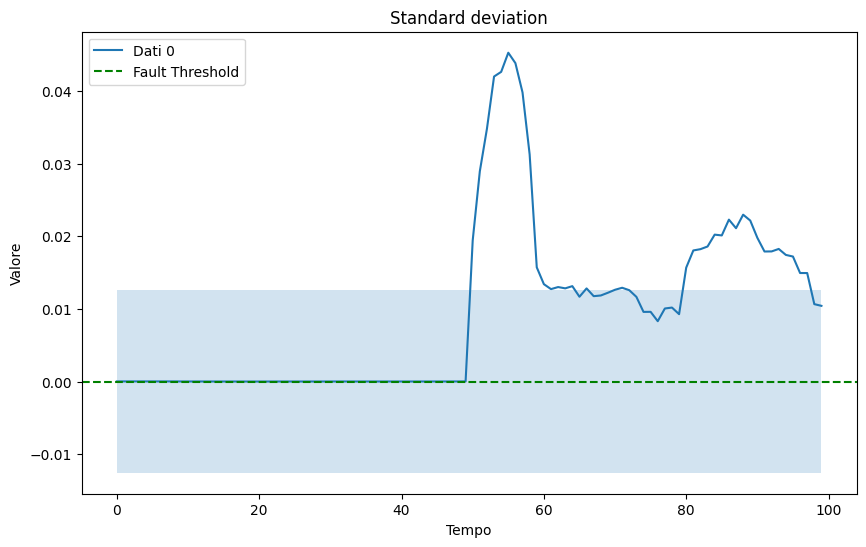

KeyboardInterrupt: 

In [11]:
# test phase
ad_labels, ad_predictions, ad_std = model.predict(x_ts, y_ts)

# plot
window = 150
zoom = 50
start = 150 - zoom
end = 150 + zoom

i = 0
# f = 1
for f,c in enumerate(df):
    std = ad_std[i, -window-zoom:-window+zoom]
    labels_eff = ts_dataset.y[i,-window-zoom:-window+zoom]
    labels_pred = ad_labels[i, -window-zoom:-window+zoom]
    treshold_eff =  np.where(labels_eff == 1)[0][0]
    treshold_pred =  np.where(labels_pred == 1)[0][0]
    plot_with_thresholds('Standard deviation', [std], sigma = model.sigma.item())  # standard deviation

    y, p = ts_dataset.x[i, -window-zoom:-window+zoom, f], ad_predictions[i, -window-zoom:-window+zoom, f]
    plot_with_thresholds(f'Timeseries prediction: {c}', [y, p], fault_indicator = treshold_eff, fault_detection_indicator = treshold_pred + 1)  # timeseries and prediction of lstm

    plot_with_thresholds(f'Labels: {c}', [ts_dataset.y[i, -window-zoom:-window+zoom], ad_labels[i, -window-zoom:-window+zoom]],fault_indicator = treshold_eff, fault_detection_indicator = treshold_pred+1)  # labels

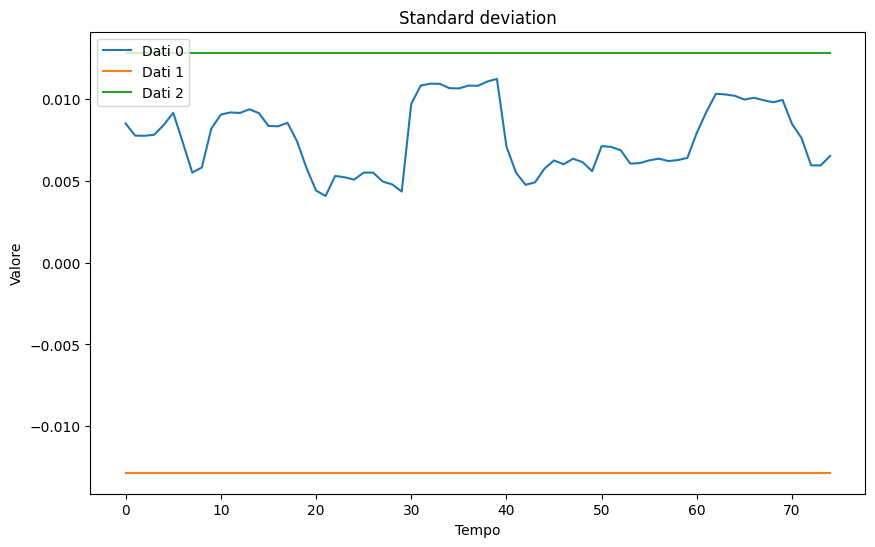

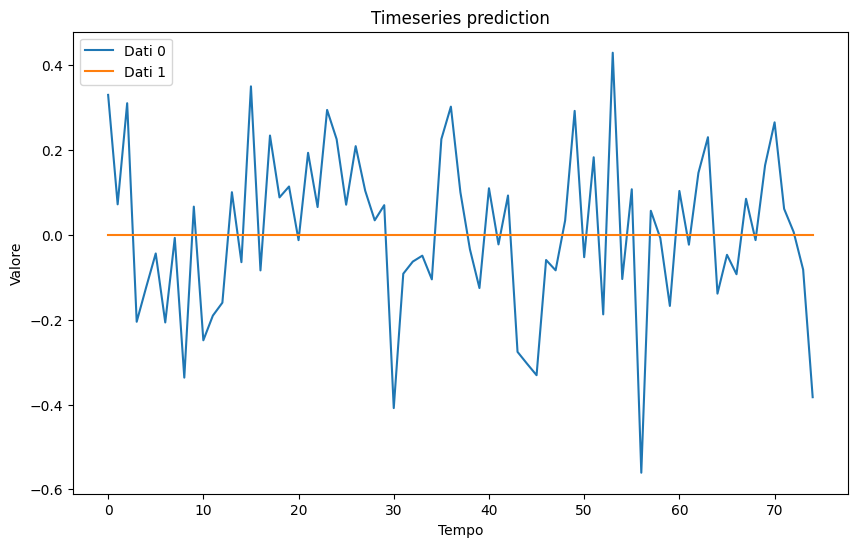

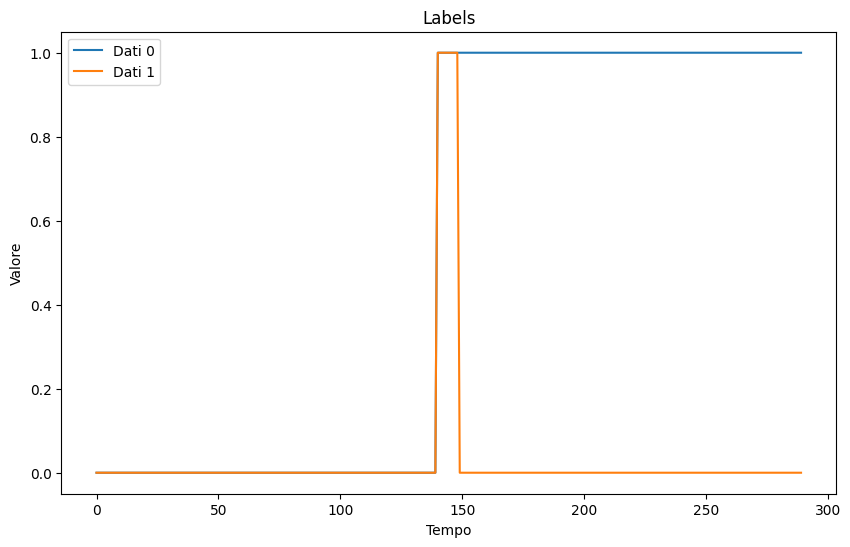

In [ ]:
# # test phase
# ad_labels, ad_predictions, ad_std = model.predict(x_ts, y_ts)

# # plot
# window = 75
# i = 0
# f = 0

# std = ad_std[i, -window:]
# m2s = torch.ones_like(std) * model.sigma.item() * (-2)
# p2s = torch.ones_like(std) * model.sigma.item() * (+2)
# plot_with_thresholds('Standard deviation', [std, m2s, p2s])  # standard deviation

# y, p = ts_dataset.x[i, -window:, f], ad_predictions[i, -window:, f]
# plot_with_thresholds('Timeseries prediction', [y, p])  # timeseries and prediction of lstm

# plot_with_thresholds('Labels', [ts_dataset.y[i, -ad_labels.shape[1]:], ad_labels[i]])  # labels